Hello! This is a notebook for forward modeling planetary systems around the disparate K2 stellar samples. The biggest challenge is piece-ing together these K2 fields. We'll be using TRILEGAL to generate stellar populations in these fields. 

K2: https://archive.stsci.edu/missions-and-data/k2/campaign-fields.html#c1 and https://archive.stsci.edu/missions-and-data/k2/documents/data-release-notes

TRILEGAL: https://stev.oapd.inaf.it/cgi-bin/trilegal_1.6 

In [48]:
import os
import os.path
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import random
from scipy.stats import gaussian_kde, loguniform, gamma
from math import lgamma
from tqdm import tqdm
from ast import literal_eval
from glob import glob
from tqdm import tqdm
from itertools import zip_longest
import numpy.ma as ma # for masked arrays
from astropy.table import Table, join
import astropy.coordinates as coord
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
from pyia import GaiaData

# these packages are for fitting with numpyro
import numpyro
from numpyro import distributions as dist, infer
import numpyro_ext
import arviz as az
import jax

# these are psps imports
from psps.transit_class import Population, Star
import psps.simulate_helpers as simulate_helpers
import psps.simulate_transit as simulate_transit
import psps.utils as utils

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
matplotlib.rcParams.update({'errorbar.capsize': 1})
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

import warnings
warnings.filterwarnings("ignore")

path = '/Users/chrislam/Desktop/psps/' 

# we're gonna need this for reading in the initial Berger+ 2020 data
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        pass

Berger+23 produced isochrone ages for Kepler/K2/TESS stars. Keep only K2 stars and remove records with uninformative ages (prepended with asterisk).

In [57]:
k2_stars = pd.read_csv(path+'data/k2/k2_stars.csv', sep=',') # originally GKTHCatalog_Table4.txt.csv from Berger+23 (https://arxiv.org/abs/2301.11338), but I just took EPIC IDs
k2_stars['EPIC'] = k2_stars['id_starname'].str.strip('epic').astype(int)
k2_stars = k2_stars[~k2_stars['iso_age'].astype(str).str.startswith('*')]
k2_stars['iso_age'] = k2_stars['iso_age'].astype(float)
k2_stars

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,iso_lum_err1,iso_lum_err2,iso_age,iso_age_err1,iso_age_err2,iso_dis,iso_dis_err1,iso_dis_err2,iso_avs,EPIC
3,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.097678,-0.087197,5.008,2.393,-2.082,462.624807,7.111266,-7.129360,0.000000,201295312
5,epic201384232,5617.490904,104.439531,-112.920238,4.504207,0.031620,-0.054677,-0.067026,0.133046,-0.128326,...,0.025452,-0.024216,3.646,5.272,-2.815,315.819173,4.697152,-4.618715,0.000000,201384232
6,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,0.116242,-0.105389,5.865,2.614,-2.373,687.530006,11.482838,-11.359304,0.192158,201393098
7,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,0.115679,-0.105381,3.633,2.205,-1.778,443.226923,7.071150,-6.956991,0.000000,201403446
9,epic201445732,5855.091952,142.109696,-165.527870,4.370385,0.057779,-0.071913,-0.008679,0.145500,-0.135597,...,0.048757,-0.045087,5.033,4.495,-3.407,311.962902,4.649414,-4.603710,0.000000,201445732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.122407,-0.118200,4.095,2.302,-1.369,455.301611,7.682692,-7.758965,0.000000,211784767
557,epic211914998,5506.434626,100.491856,-107.050256,4.516862,0.029614,-0.053160,-0.003695,0.138075,-0.129787,...,0.023404,-0.022061,3.628,5.515,-2.820,467.044835,7.464813,-7.324307,0.109805,211914998
559,epic211929937,5120.873317,85.776292,-93.976022,4.541658,0.036672,-0.059382,0.092489,0.139585,-0.138446,...,0.015634,-0.014883,6.549,8.667,-5.032,500.969658,9.269712,-9.221000,0.000000,211929937
560,epic211962097,6212.505919,166.837618,-154.772263,3.931147,0.049014,-0.062616,-0.164533,0.138264,-0.129350,...,0.341469,-0.312011,3.474,0.749,-0.759,1381.767640,35.287033,-34.141219,0.000000,211962097


In [58]:
# cross match with ingredients from same paper, to calculate Zmax; originally GKTHCatalog_Table2.txt.csv from Berger+23 (https://arxiv.org/abs/2301.11338), but I just took EPIC IDs
berger23_table2 = pd.read_csv(path+'data/k2/berger23_table2_source_ids.csv')
berger23_table2 = berger23_table2[berger23_table2['id_starname'].str.startswith('epic')]
berger23_table2['EPIC'] = berger23_table2['id_starname'].str.strip('epic').astype(int)

k2_stars = pd.merge(k2_stars, berger23_table2, on=['id_starname', 'EPIC'])
k2_stars

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,bpmag,bpmag_err,rpmag,rpmag_err,parallax,parallax_err,feh,feh_err,feh_prov,ruwe
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,12.336206,0.002874,11.533532,0.003810,2.157181,0.0146,0.146637,0.15,Poly,0.823
1,epic201384232,5617.490904,104.439531,-112.920238,4.504207,0.031620,-0.054677,-0.067026,0.133046,-0.128326,...,12.826021,0.002850,11.992009,0.003801,3.167135,0.0168,0.021680,0.15,Poly,0.929
2,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,13.383867,0.002883,12.542809,0.003794,1.451126,0.0133,-0.220733,0.15,Poly,1.001
3,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,12.159136,0.002849,11.496057,0.003801,2.252150,0.0170,-0.213078,0.15,Poly,0.956
4,epic201445732,5855.091952,142.109696,-165.527870,4.370385,0.057779,-0.071913,-0.008679,0.145500,-0.135597,...,12.193864,0.002862,11.386943,0.003798,3.200969,0.0172,0.001283,0.15,Poly,0.887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,12.113058,0.002838,11.360767,0.003789,2.195042,0.0206,0.050559,0.15,Poly,1.294
338,epic211914998,5506.434626,100.491856,-107.050256,4.516862,0.029614,-0.053160,-0.003695,0.138075,-0.129787,...,13.935163,0.002913,13.020940,0.003828,2.143024,0.0170,0.102435,0.15,Poly,0.976
339,epic211929937,5120.873317,85.776292,-93.976022,4.541658,0.036672,-0.059382,0.092489,0.139585,-0.138446,...,14.598705,0.003176,13.567505,0.003859,1.997430,0.0247,0.153934,0.15,Poly,1.111
340,epic211962097,6212.505919,166.837618,-154.772263,3.931147,0.049014,-0.062616,-0.164533,0.138264,-0.129350,...,13.765182,0.002898,13.070049,0.003862,0.719913,0.0156,-0.194291,0.15,Poly,0.980


In [51]:
# K2 doesn't come with CDPP. Instead, Aigrain+15 report a table of quasi-CDPPs, with the caveat that the durations are going to be different because shorter campaigns mean shorter period planets, which mean shorter : https://academic.oup.com/mnras/article/447/3/2880/2892909

In [52]:
k2_stars.columns

Index(['id_starname', 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'iso_logg',
       'iso_logg_err1', 'iso_logg_err2', 'iso_feh', 'iso_feh_err1',
       'iso_feh_err2', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'iso_age_err1', 'iso_age_err2', 'iso_dis', 'iso_dis_err1',
       'iso_dis_err2', 'iso_avs', 'EPIC', 'dr3_source_id', 'bpmag',
       'bpmag_err', 'rpmag', 'rpmag_err', 'parallax', 'parallax_err', 'feh',
       'feh_err', 'feh_prov', 'ruwe'],
      dtype='object')

#### Bootstrapping and cuts

In [61]:
def draw_asymmetrically(df, mode_name, err1_name, err2_name, drawn):
    """
    Draw stellar properties with asymmetric errors. 
    This is the generalized version of draw_star_ages(), below
    
    Inputs:
    - df: berger_kepler [Pandas DataFrame]
    - mode_name: name of mode column [string]
    - err1_name: name of err1 column [string]
    - err2_name: name of err2 column [string]
    - drawn: name of new column [string]

    Output:
    - df: berger_kepler_df, now with new column with drawn parameter, "drawn" [Pandas DataFrame]
    """

    # in case df is broken up by planet and not star
    uniques = df
    
    if drawn=='age':
        x = np.linspace(0.5, 13.5, 100)
    elif drawn=='gyro_age':
        x = np.linspace(0.5, 4., 100)
    elif drawn=='stellar_radius':
        x = np.linspace(0.5, 5., 100)
    elif drawn=='stellar_mass':
        x = np.linspace(0.5, 2.5, 100)
    elif drawn=='Teff':
        x = np.linspace(3400, 8000, 1000) # x = np.linspace(3700, 7500, 1000); Z23 did (4000, 6500, 1000); originally I did (5300, 7500), but let's just make cuts separately
    elif drawn=='stellar_feh':
        x = np.linspace(-0.5, 0.5, 100)
    elif drawn=='distance':
        x = np.linspace(0, 5000, 1000)
    elif drawn=='planet_radius':
        x = np.linspace(0.5, 10, 100)
    elif drawn=='logg':
        x = np.linspace(3., 5., 1000)  # formerly 3.6 to 4.7 over 100, but there were sampling artifacts due to low resolution and incomplete coverage

    else: 
        print("Please create a column that is either age, gyro_age, stellar_radius, stellar_mass, distance, planet_radius, stellar_feh, or stellar_teff!")

    """
    TESTING
    print("x: ", x)
    pdf = make_pdf_rows(x, mode, err1, err2)
    pdf = pdf/np.sum(pdf)
    draw = np.around(np.random.choice(x, p=pdf), 2)
    print("draw: ", draw)
    """

    if drawn=='planet_radius':
        df_or_uniques = df
    else:
        df_or_uniques = uniques

    draws = np.ones(len(df_or_uniques))
    for i in range(len(df_or_uniques)):
        mode = df_or_uniques.iloc[i][mode_name]
        err1 = df_or_uniques.iloc[i][err1_name]
        err2 = np.abs(df_or_uniques.iloc[i][err2_name])
        
        #"""
        # symmetric uncertainties
        if err1==err2:
            if drawn!='stellar_feh':
                draw = 0
                while draw <= 0: # make sure the draw is positive
                    draw = np.random.normal(mode, err1) # I used to round this to two decimal places but I don't know why I did this.
            elif drawn=='stellar_feh':
                draw = np.random.normal(mode, err1)

        # asymmetric uncertainties
        elif err1!=err2:
            try:
                pdf = make_pdf_rows(x, mode, err1, err2)
                pdf = pdf/np.sum(pdf)
            except Exception as e:
                print(e)
                print(x, mode, err1, err2)

            try:
                if drawn!='stellar_feh':
                    draw = 0
                    while draw <= 0: # make sure the draw is positive
                        draw = np.random.choice(x, p=pdf)
                elif drawn=='stellar_feh':
                    draw = np.random.choice(x, p=pdf)
            except Exception as e:
                #print("EXCEPTION: ", i, pdf, mode, err1, err2)
                #print(e)
                continue
        #"""
        #if draw==1.:
        #    print(draw, mode, err1, err2)
        
        """
        ### make all draws the same way, symmetric or asymmetric
        pdf = make_pdf_rows(x, mode, err1, err2)
        pdf = pdf/np.sum(pdf)

        try:
            draw = 0
            while draw <= 0: # make sure the draw is positive
                draw = np.around(np.random.choice(x, p=pdf), 2)
        except Exception as e:
            print("EXCEPTION: ", i, pdf, mode, err1, err2)
            print(e)
            break
        """

        #print(mode, err1, err2, draw)
        draws[i] = draw

    #print(len(df), len(draws), len(uniques))
    df_or_uniques[drawn] = draws

    # break back out into planet rows and forward fill across systems
    #df = uniques.merge(df, how='right')
    #df[drawn] = df[drawn].fillna(method='ffill')
    
    return df_or_uniques

### adapted from The Cannon project with Aida
def tighter_cull(comparison_df, comparison_teff, comparison_logg):

    comparison_df = comparison_df.loc[((comparison_logg<4.4) & (comparison_teff<6300))]
    comparison_df = comparison_df.loc[((comparison_logg>3.4) & (comparison_teff>5300))]

    return comparison_df

def make_pdf_rows(x, mode, err1, err2):
    """
    Row-wise likelihood of asymmetric uncertainty, using Eqn 6 from https://iopscience.iop.org/article/10.3847/1538-3881/abd93f
    Less efficient, but row-wise in order to troubleshoot. 
    Takes in scalar values for mode, err1, and err2, not arrays.

    Input:
    - x: np.linspace(0.5, 10, 100); just something to undergird the PDF and represent stellar ages
    - mode: mean age; peak of asymmetric PDF
    - err1: + uncertainty
    - err2: - uncertainty (note: must be positive)

    Output:
    - pdf: asymmetric PDF

    """
    
    factor1 = 1/np.sqrt(2*np.pi*err1**2) 
    beta = err1/err2
    gamma = (err1 - np.abs(err2))/(err1 * np.abs(err2))
    
    factor2_arg_a = np.log(1+gamma*(x - mode))
    factor2_arg_b = np.log(beta)
    factor2_arg = factor2_arg_a/factor2_arg_b
    factor2 = np.exp(-0.5*(factor2_arg)**2)

    out = factor1 * factor2
    out[~np.isfinite(out)] = 0.0
    
    return out


#### Calculate Zmax

In [67]:
from astroquery.gaia import Gaia
import pandas as pd

# list of Gaia DR3 source IDs
k2_source_ids = list(k2_stars.dr3_source_id)

# convert to ADQL list
k2_source_list = ",".join(str(s) for s in k2_source_ids)

query = f"""
SELECT source_id,
       ra, dec,
       parallax,
       pmra, pmdec,
       radial_velocity,
	   ra_error, dec_error, parallax_error, pmra_error, pmdec_error, radial_velocity_error
FROM gaiadr3.gaia_source
WHERE source_id IN ({k2_source_list})
"""

job = Gaia.launch_job_async(query)
results = job.get_results()

k2_astrometry = results.to_pandas()
k2_astrometry

INFO: Query finished. [astroquery.utils.tap.core]


,SOURCE_ID,ra,dec,parallax,pmra,pmdec,radial_velocity,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error
0,61624573016925824,52.888851,22.434817,4.615705,-7.942969,-10.844134,0.973049,0.013907,0.010376,0.014570,0.019928,0.014409,1.377523
1,651522834880015872,129.140536,14.461881,13.217502,89.722146,-12.271023,-33.727615,0.015832,0.010264,0.017178,0.018632,0.013662,0.264967
2,655863775507590400,125.223916,16.090791,1.840995,9.805472,-34.567896,-69.233032,0.016108,0.010309,0.018952,0.017103,0.012747,2.652549
3,2599322178998513664,337.044246,-14.599336,4.264093,-3.042030,11.698896,-8.641218,0.017266,0.013766,0.020042,0.020922,0.015885,1.052269
4,2639417798946571648,353.707773,-3.834946,2.732386,21.013893,-8.183468,-47.833054,0.015846,0.013830,0.018649,0.019046,0.016881,2.507941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,4087372834886655104,285.900107,-18.310261,0.801389,-3.021629,-2.410988,3.784722,0.024495,0.024382,0.032710,0.032217,0.021256,1.094914
338,4131047326528868352,249.025160,-19.744525,4.820182,-42.987354,27.625167,-19.482119,0.014415,0.008110,0.016637,0.020089,0.012777,0.913476
339,6260472256256074496,236.840933,-17.610816,1.796603,-5.279529,-1.473174,-23.022844,0.015793,0.011815,0.017826,0.021732,0.014753,1.583088
340,6260956007012322688,237.010174,-16.842446,1.832531,-3.341281,-7.565473,NaN,0.016949,0.012642,0.018962,0.022718,0.015620,NaN


In [68]:
k2_stars = pd.merge(k2_stars, k2_astrometry, left_on='dr3_source_id', right_on='SOURCE_ID')
k2_stars

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,parallax_y,pmra,pmdec,radial_velocity,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,2.121736,6.614481,-12.365250,45.586647,0.014309,0.009947,0.014552,0.023659,0.011433,0.764247
1,epic201384232,5617.490904,104.439531,-112.920238,4.504207,0.031620,-0.054677,-0.067026,0.133046,-0.128326,...,3.140299,-32.251641,7.325712,7.041161,0.012282,0.009171,0.016791,0.017660,0.011535,1.071830
2,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,1.410998,-4.657043,-23.646633,-4.040172,0.012669,0.010187,0.013297,0.015633,0.012143,2.168792
3,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,2.206281,-21.811427,13.824365,18.894762,0.014046,0.011357,0.016955,0.016465,0.012123,1.045084
4,epic201445732,5855.091952,142.109696,-165.527870,4.370385,0.057779,-0.071913,-0.008679,0.145500,-0.135597,...,3.157658,2.811996,-20.806328,-35.101978,0.013434,0.012602,0.017214,0.015770,0.014879,1.030092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,2.147117,6.734759,-16.367881,6.481744,0.017554,0.012035,0.020601,0.019146,0.014207,0.576840
338,epic211914998,5506.434626,100.491856,-107.050256,4.516862,0.029614,-0.053160,-0.003695,0.138075,-0.129787,...,2.099473,-21.047147,-11.894266,33.985680,0.014355,0.006844,0.016967,0.017220,0.011867,1.617407
339,epic211929937,5120.873317,85.776292,-93.976022,4.541658,0.036672,-0.059382,0.092489,0.139585,-0.138446,...,1.954357,-9.471131,-1.815192,1.068546,0.019468,0.013214,0.024675,0.024626,0.017039,4.315491
340,epic211962097,6212.505919,166.837618,-154.772263,3.931147,0.049014,-0.062616,-0.164533,0.138264,-0.129350,...,0.676152,-5.345947,3.467558,32.060375,0.014103,0.008343,0.015626,0.016552,0.012772,6.055880


In [69]:
def gala_galactic_heights_k2(df, output=True):


    """
    Use Gala (Price-Whelan+) to simulate orbits of Gaia stars and get their Z_maxes
    """

    """
    # merge sample with Megan Bedell's Gaia-Kepler cross-match because those save info on RV, proper motion, parallax, etc required for Gala
    berger = Table.read(path+'data/berger_kepler_stellar_fgk.csv')
    megan = Table.read(path+'data/kepler_dr3_good.fits')
    merged = join(berger, megan, keys='kepid')
    merged.rename_column('parallax_2', 'parallax')
    #print(merged[['parallax', 'parallax_error', 'radial_velocity', 'radial_velocity_error']])
    """

    df['radial_velocity'] = np.random.normal(df['radial_velocity'], df['radial_velocity_error'])
    df['pmra'] = np.random.normal(df['pmra'], df['pmra_error'])
    df['pmdec'] = np.random.normal(df['pmdec'], df['pmdec_error'])
    df['parallax'] = np.random.normal(df['parallax'], df['parallax_err'])

    # mise en place
    with coord.galactocentric_frame_defaults.set("v4.0"):
        galcen_frame = coord.Galactocentric()

    sun_xyz = u.Quantity(
        [-galcen_frame.galcen_distance, 0 * u.kpc, galcen_frame.z_sun]  # x  # y  # z
    )

    sun_w0 = gd.PhaseSpacePosition(pos=sun_xyz, vel=galcen_frame.galcen_v_sun)

    mw_potential = gp.MilkyWayPotential()

    sun_orbit = mw_potential.integrate_orbit(sun_w0, dt=0.5 * u.Myr, t1=0, t2=4 * u.Gyr)

    star_gaia = GaiaData(df)

    star_gaia_c = star_gaia.get_skycoord()
    star_galcen = star_gaia_c.transform_to(galcen_frame)
    star_w0 = gd.PhaseSpacePosition(star_galcen.data)

    # calculate orbits and retrieve Z_maxes
    zmaxes = []
    for i in tqdm(range(len(star_gaia))):
    #for i in range(1000):
        star_orbit = mw_potential.integrate_orbit(star_w0[i], t=sun_orbit.t) 
        zmax = star_orbit.zmax().value
        zmaxes.append(zmax)

    zmaxes_df = pd.DataFrame({'height': zmaxes})
    #zmaxes_df.to_csv(path+'data/zmaxes.csv', index=False)
    
    return zmaxes

In [73]:
k2_stars['parallax'] = k2_stars['parallax_x']
k2_stars['height'] = gala_galactic_heights_k2(Table.from_pandas(k2_stars))

100%|██████████| 342/342 [00:02<00:00, 163.66it/s]


In [87]:
# fractional age cuts
k2_stars['fractional_err1'] = k2_stars.iso_age_err1/k2_stars.iso_age
k2_stars['fractional_err2'] = k2_stars.iso_age_err2/k2_stars.iso_age
print(np.nanmedian(k2_stars.iso_age_err1/k2_stars.iso_age))
print(np.nanmedian(k2_stars.iso_age_err2/k2_stars.iso_age))
k2_stars_age = k2_stars.loc[(k2_stars.fractional_err1 <= 1.15) & (np.abs(k2_stars.fractional_err2) <= 0.74)] # 0.5 and 0.4, vs 1.15 and 0.74
print("age uncertainty cut: ", len(k2_stars_age))

# remove stars without full astrometric solution
# never mind, later on I can use Astroquery to get them for all 342 stars

k2_stars_bootstrapped = pd.DataFrame()
len_teff_cut = []
len_giant_cut = []
len_logg_cut = []
len_metal_cut = []
len_age_cut = []
for i in tqdm(range(10)):

	k2_stars_temp = draw_asymmetrically(k2_stars_age, 'iso_age', 'iso_age_err1', 'iso_age_err2', 'age')
	k2_stars_temp = draw_asymmetrically(k2_stars_temp, 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'Teff')
	k2_stars_temp = draw_asymmetrically(k2_stars_temp, 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'logg')
	k2_stars_temp = draw_asymmetrically(k2_stars_temp, 'iso_rad', 'iso_rad_err1', 'iso_rad_err2', 'stellar_radius')
	k2_stars_temp = draw_asymmetrically(k2_stars_temp, 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'stellar_feh')

	# remove stars beyond [3900, 7500] K Teff, ie. keep only FGK stars
	k2_stars_temp = k2_stars_temp.loc[(k2_stars_temp['Teff'] <= 7500) & (k2_stars_temp['Teff'] >= 3900)]
	#print("teff cut: ", len(kepler_stars_temp))
	len_teff_cut.append(len(k2_stars_temp))

	# isolate giant stars
	# using unnumbered equation in first paragraph of Sec 4.2.1 ("Sample Selection") in Berger et al 2020b 
	k2_stars_temp['logR'] = np.log10(k2_stars_temp.stellar_radius)
	k2_stars_temp['is_giant'] = np.where(k2_stars_temp['logR'] >= 0.00035*(k2_stars_temp['Teff'] - 4500) + 0.15, True, False)
	k2_stars_temp = k2_stars_temp.loc[k2_stars_temp['is_giant'] == False]
	#print("giant cut: ", len(kepler_stars_temp))
	len_giant_cut.append(len(k2_stars_temp))

	# remove poofy stars that the giant cut didn't remove
	k2_stars_temp = k2_stars_temp.loc[(k2_stars_temp['logg']<4.7)& (k2_stars_temp['logg']>4.)]
	len_logg_cut.append(len(k2_stars_temp))

	# remove stars outside of Solar metallicity +/- 0.25 dex
	k2_stars_temp = k2_stars_temp.loc[(k2_stars_temp['feh']<=0.25) & (k2_stars_temp['feh']>=-0.25)]
	len_metal_cut.append(len(k2_stars_temp))

	# remove stars older than 12 Gyr
	k2_stars_temp = k2_stars_temp.loc[k2_stars_temp['age']<=12.]
	len_age_cut.append(len(k2_stars_temp))
	
	k2_stars_bootstrapped = pd.concat([k2_stars_bootstrapped, k2_stars_temp])

print("teff cut: ", np.mean(len_teff_cut), np.std(len_teff_cut))
print("giant cut: ", np.mean(len_giant_cut), np.std(len_giant_cut))
print("logg cut: ", np.mean(len_logg_cut), np.std(len_logg_cut))
print("metal cut: ", np.mean(len_metal_cut), np.std(len_metal_cut))
print("age cut: ", np.mean(len_age_cut), np.std(len_age_cut))

print(len(k2_stars_bootstrapped))



1.1535363443582716
-0.7357143284466074
age uncertainty cut:  166


100%|██████████| 10/10 [00:01<00:00,  8.83it/s]

teff cut:  164.1 0.7000000000000001
giant cut:  162.4 1.7435595774162693
logg cut:  136.9 2.118962010041709
metal cut:  102.9 1.445683229480096
age cut:  98.2 2.2271057451320084
982


0       6.277778
2       9.429293
3       2.207071
13      7.722222
22      7.328283
         ...    
322    11.398990
326    10.742424
334     8.772727
335     3.388889
337     3.782828
Name: age, Length: 982, dtype: float64
0      792.690697
2      838.486699
3      615.330049
13      49.705359
22     305.164506
          ...    
322    331.404007
326    426.451687
334    692.183209
335    665.649320
337    282.480876
Name: height, Length: 982, dtype: float64


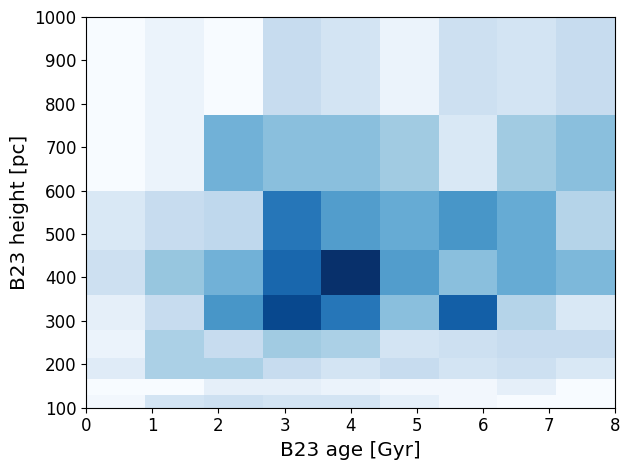

In [97]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='B23'
ages = k2_stars_bootstrapped['age']
heights = k2_stars_bootstrapped['height']*1000
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B23':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B23 age [Gyr]')
	plt.ylabel('B23 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_B23_bootstrapped.png')
plt.show()

#### Kiel diagram

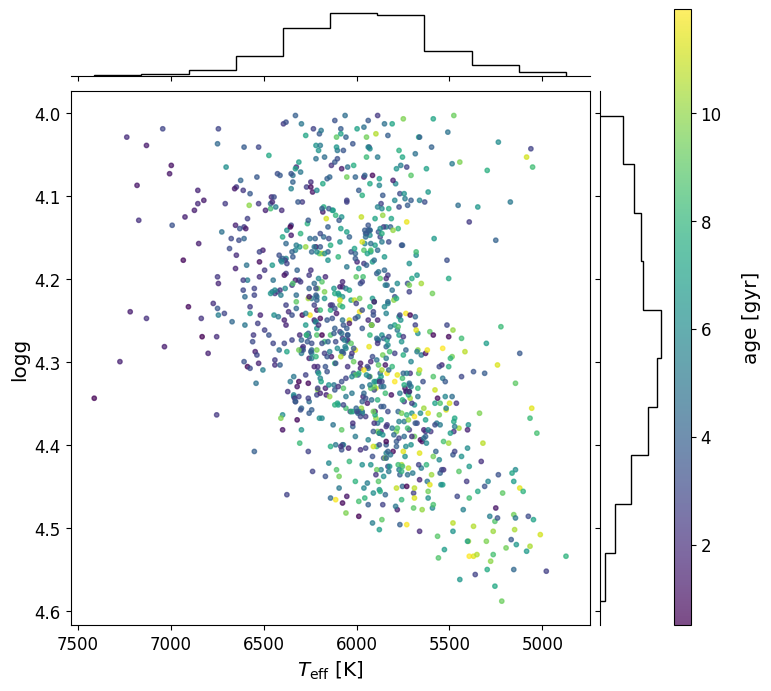

In [92]:
from matplotlib.gridspec import GridSpec

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 3, figure=fig, wspace=0.05, hspace=0.05, width_ratios=[8, 1, 0.25], height_ratios=[1, 8]) # two horizontal assets, but third vertical asset required for colorbar

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1, 0])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.00, pos.width, pos.height])
ax_histx.set_yticks([])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
ax_histy.set_xticks([])

im = ax_scatter.scatter(k2_stars_bootstrapped['Teff'], k2_stars_bootstrapped['logg'], s=10, alpha=0.7, c=k2_stars_bootstrapped['age'])

# histograms
ax_histx.hist(k2_stars_bootstrapped['Teff'], bins=10, histtype='step', color="k", linewidth=1)
ax_histy.hist(k2_stars_bootstrapped['logg'], bins=10, orientation='horizontal', histtype='step', color="k", linewidth=1)
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
#ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

# add colorbar as final asset
ax_cbar = fig.add_subplot(gs[:, 2])

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K]")
ax_scatter.set_ylabel('logg')
#plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
#ax_scatter.set_xlim([7600, 3900])
#ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label='age [Gyr]')
cbar = fig.colorbar(im, cax=ax_cbar)
cbar.set_label('age [gyr]', labelpad=15)
cbar.ax.yaxis.set_label_position("right")
plt.tight_layout()
plt.savefig(path+'plots/k2/kiel_b23_k2.png')
plt.show()

### Skip to 3D Positions section below

In [6]:
# oh cool the Scaling K2 pt 2 paper has CDPPs! Zink+20: https://iopscience.iop.org/article/10.3847/1538-3881/ab7448#ajab7448t3
k2_cdpps = pd.read_csv(path+'data/k2/scaling_k2_pt2_table1_cdpp.txt',sep='\s+')
print(k2_cdpps)
#k2_stars = pd.merge(k2_stars, k2_cdpps[['EPIC', 'CDPP60']], on='EPIC')
#print(k2_stars)

            EPIC    CDPP10    CDPP15    CDPP20    CDPP25    CDPP30    CDPP40  \
0      211757991   144.911   136.083   121.719   113.490   109.661    98.879   
1      212029436  1584.883  1467.489  1497.115  1371.193  1308.514  1191.682   
2      211682710   108.918    89.812    82.123    69.502    64.331    58.029   
3      211429539  1281.174  1020.636   917.835   835.924   780.876   687.515   
4      211828625   360.837   291.578   259.953   227.798   210.414   183.354   
...          ...       ...       ...       ...       ...       ...       ...   
25026  211802909   432.860   386.795   387.898   364.690   325.346   326.565   
25027  211490307  1292.834  1309.788  1254.581  1465.099  1199.701  1210.272   
25028  211409713   847.386   812.311   748.193   760.363   766.329   758.434   
25029  211566738   360.844   320.730   266.292   268.193   251.256   207.198   
25030  212163345   679.142   633.067   530.748   456.516   447.219   389.510   

         CDPP50    CDPP60    CDPP70    

In [7]:
k2_stars.columns

Index(['id_starname', 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'iso_logg',
       'iso_logg_err1', 'iso_logg_err2', 'iso_feh', 'iso_feh_err1',
       'iso_feh_err2', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'iso_age_err1', 'iso_age_err2', 'iso_dis', 'iso_dis_err1',
       'iso_dis_err2', 'iso_avs', 'EPIC', 'dr3_source_id', 'bpmag',
       'bpmag_err', 'rpmag', 'rpmag_err', 'parallax', 'parallax_err', 'feh',
       'feh_err', 'feh_prov', 'ruwe'],
      dtype='object')

In [8]:
k2_planets = pd.read_csv(path+'data/k2/k2_planets.csv', sep=',') # originally GKTHCatalog_Table5.txt.csv from Berger+23 (https://arxiv.org/abs/2301.11338), but I just took EPIC IDs
k2_planets

,id_starname,id_planet,disposition,orbper,orbper_err1,orbper_err2,rprstar,rprstar_err1,rprstar_err2,prad,prad_err1,prad_err2,sma,sma_err1,sma_err2,insol,insol_err1,insol_err2
0,epic201155177,epic201155177.01,KP,6.689040,0.000796,-0.000871,0.0285,0.001,-0.001,2.152833,0.094962,-0.100569,0.061054,0.001093,-0.001234,49.116873,3.183305,-4.934830
1,epic201208431,epic201208431.01,KP,10.004208,0.000881,-0.000858,0.0352,0.001,-0.001,2.474641,0.091672,-0.088239,0.077375,0.000856,-0.000860,17.274730,1.036056,-0.856952
2,epic201247497,epic201247497.01,PC,2.754012,0.000122,-0.000132,0.0917,0.028,-0.019,6.823819,2.094023,-1.432153,0.033392,0.000402,-0.000663,116.013351,15.739793,-14.915886
3,epic201295312,epic201295312.01,KP,5.656766,0.000276,-0.000323,0.0171,0.000,-0.000,2.731644,0.138787,-0.129256,0.065229,0.001604,-0.001460,567.311866,36.131216,-32.633066
4,epic201338508,epic201338508.01,KP,10.934881,0.000982,-0.001177,0.0315,0.002,-0.001,2.019263,0.139334,-0.084410,0.079864,0.000936,-0.000505,11.831787,0.552315,-0.462909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,epic211962097,epic211962097.01,LPPC,5.839233,0.000095,-0.000112,0.0947,0.000,-0.001,20.977987,1.001641,-0.982876,0.069063,0.001733,-0.001778,1172.787800,92.683066,-89.019938
672,epic211990866,epic211990866.01,KP,1.673847,0.000040,-0.000042,0.0296,0.001,-0.001,3.741022,0.194765,-0.167309,0.028937,0.000338,-0.000665,1909.568588,85.525794,-111.179584
673,epic212009150,epic212009150.01,PC,6.832256,0.000644,-0.000750,0.0602,0.005,-0.005,1.548175,0.150864,-0.148084,0.041852,0.000629,-0.000685,3.214271,0.200392,-0.169147
674,epic212035441,epic212035441.01,PC,2.714743,0.000277,-0.000276,0.0264,0.001,-0.001,1.144098,0.066527,-0.065158,0.027550,0.000230,-0.000487,23.633212,2.182990,-1.923210


In [9]:
list(k2_planets.columns)

['id_starname',
 'id_planet',
 'disposition',
 'orbper',
 'orbper_err1',
 'orbper_err2',
 'rprstar',
 'rprstar_err1',
 'rprstar_err2',
 'prad',
 'prad_err1',
 'prad_err2',
 'sma',
 'sma_err1',
 'sma_err2',
 'insol',
 'insol_err1',
 'insol_err2']

### TRILEGAL (from Sarah)

These are TESS TRILEGAL query results, using the same search parameters from Muirhead+18: https://iopscience.iop.org/article/10.3847/1538-3881/aab710

In [20]:
from astropy.io import fits

In [30]:
# K2 campaign pointings, from https://archive.stsci.edu/missions-and-data/k2/campaign-fields
ras = [173.939610, 246.1264, 336.66534641439, 59.0759116, 130.1576478, 204.8650344, 287.82850661, 16.3379975, 270.3544823, 186.7794430,
	   260.3880064, 351.6588124, 72.7971166, 160.6824762, 233.6175730, 133.7099689, 202.5496152, 
	   130.1610170, 347.2590265]
decs = [1.4172989, -22.4473, -11.096663792177, 18.6605794, 16.8296140, -11.2953585, -23.36001815, 5.2623459, -21.7798098, -4.0271572,
		-23.9759578, -5.1023328, 20.7870759, 6.8509316, -20.0792397, 18.5253931, -7.7210759, 
		16.8278629, -4.2027029]
campaigns = np.arange(19)+1
highs = [1, 3, 6, 8, 10, 12, 14, 17, 19]
lows = [2, 4, 5, 7, 9, 11, 13, 15, 16, 18]
k2_pointings = dict({'campaign': campaigns, 'ra': ras, 'dec': decs})
print(k2_pointings)


{'campaign': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]), 'ra': [173.93961, 246.1264, 336.66534641439, 59.0759116, 130.1576478, 204.8650344, 287.82850661, 16.3379975, 270.3544823, 186.779443, 260.3880064, 351.6588124, 72.7971166, 160.6824762, 233.617573, 133.7099689, 202.5496152, 130.161017, 347.2590265], 'dec': [1.4172989, -22.4473, -11.096663792177, 18.6605794, 16.829614, -11.2953585, -23.36001815, 5.2623459, -21.7798098, -4.0271572, -23.9759578, -5.1023328, 20.7870759, 6.8509316, -20.0792397, 18.5253931, -7.7210759, 16.8278629, -4.2027029]}


In [14]:
tri1 = path+'data/k2/sarah_trilegal/trilegal_0_499.fits'
hdul1 = fits.open(tri1)    
hdul1[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.6a           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  254 /Number of bytes per row                         
NAXIS2  =               738179 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   28 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

### Start here for my own TRILEGAL run! 

#### kepmag to cdpp

In [93]:
def kepmag_to_cdpp_vectorized(data1, data2):

    """
    Use Kepler mag vs CDPP (6 hr) relation from Berger Kepler-Gaia crossmatch to infer CDPP given simulated kepmag from TRILEGAL, etc
    Fold in Teff and galactic height, since these bear indirectly on noise properties and directly on experimental dependent variables
    Inputs:
    - data1: reference DataFrame, with Kepler mag and CDPP
    - data2: target DataFrame from which to sample

    Output:
    #- cdpps: new array of CDPPs
    - new_data2: this operation culls records that have NaN heights, etc. So let's use this opportunity to cull the entire DF, rather than output a column of different length from the original
    """

    cols_to_match = ['mag_bins', 'teff_bins', 'logg_bins']
    logg_bins = np.linspace(3.0, 4.6, 5) 
    teff_bins = np.linspace(5300, 7500, 50) # (5300, 7500, 50) or (4000, 6500, 50)
    mag_bins = np.linspace(8, 16, 5)
    age_bins = np.linspace(0, 14, 10) # (0, 14, 10) or (0, 8, 10)
    stellar_radius_bins = np.linspace(1, 3.5, 5)
    cdpp_bins = np.linspace(0, 1000, 10) # (0, 100, 10)
    height_bins = np.logspace(2,3,6)
    
    # reference DataFrame
    data1['mag_bins'] = pd.cut(data1['kepmag'], bins=mag_bins, include_lowest=True)
    data1['logg_bins'] = pd.cut(data1['iso_logg'], bins=logg_bins, include_lowest=True)
    data1['teff_bins'] = pd.cut(data1['iso_teff'], bins=teff_bins, include_lowest=True)
    #data1['stellar_radius_bins'] = pd.cut(data1['iso_rad'], bins=stellar_radius_bins, include_lowest=True)
    #data1['cdpp_bins'] = pd.cut(data1['rrmscdpp06p0'], bins=cdpp_bins, include_lowest=True)
    #data1['height_bins'] = pd.cut(data1['height'], bins=height_bins, include_lowest=True)
    #data1['age_bins'] = pd.cut(data1['age'], bins=age_bins, include_lowest=True)

    data1_cdpp_mean = data1.groupby(cols_to_match)['rrmscdpp06p0'].mean().reset_index()
    data1_cdpp_mean = data1_cdpp_mean.pivot(index='mag_bins', columns=cols_to_match[1:])

    data1_cdpp_std = data1.groupby(cols_to_match)['rrmscdpp06p0'].std().reset_index()
    data1_cdpp_std = data1_cdpp_std.pivot(index='mag_bins', columns=cols_to_match[1:])

    # unstack pivot tables
    data1_unstacked_mean = data1_cdpp_mean.unstack().reset_index()
    data1_unstacked_mean = data1_unstacked_mean[['mag_bins', 'teff_bins', 'logg_bins', 0]]
    data1_unstacked_mean.columns = ['mag_bins', 'teff_bins', 'logg_bins','cdpp_mean']
    data1_unstacked_mean.dropna(subset=['cdpp_mean'], inplace=True)
    #print(data1_unstacked_mean)

    data1_unstacked_std = data1_cdpp_std.unstack().reset_index()
    data1_unstacked_std = data1_unstacked_std[['mag_bins', 'teff_bins', 'logg_bins', 0]]
    data1_unstacked_std.columns = ['mag_bins', 'teff_bins', 'logg_bins','cdpp_std']
    data1_unstacked_std.dropna(subset=['cdpp_std'], inplace=True)
    #print(data1_unstacked_std)

    # target DataFrame from which to sample
    data2['mag_bins'] = pd.cut(data2['Kepler'], bins=mag_bins, include_lowest=True)
    data2['logg_bins'] = pd.cut(data2['logg'], bins=logg_bins, include_lowest=True)
    data2['teff_bins'] = pd.cut(data2['Teff'], bins=teff_bins, include_lowest=True)
    #data2['stellar_radius_bins'] = pd.cut(data2['stellar_radius'], bins=stellar_radius_bins, include_lowest=True)
    #data2['cdpp_bins'] = pd.cut(data2['cdpp'], bins=cdpp_bins, include_lowest=True)
    #data2['height_bins'] = pd.cut(data2['height'], bins=height_bins, include_lowest=True)
    #data2['age_bins'] = pd.cut(data2['age'], bins=age_bins, include_lowest=True)
    #print(data2)

    # merge the DataFrames on the multiple columns
    new_data2 = pd.merge(data2, data1_unstacked_mean, on=cols_to_match, how='inner')
    new_data2.dropna(subset=['cdpp_mean'], inplace=True)

    new_data2 = pd.merge(new_data2, data1_unstacked_std, on=cols_to_match, how='inner')
    new_data2.dropna(subset=['cdpp_std'], inplace=True)
    #print(new_data2)

    # sample from target
    new_data2['cdpp'] = np.random.normal(new_data2['cdpp_mean'], new_data2['cdpp_std'])

    return new_data2

#### calculate Zmax

In [10]:
from astroquery.gaia import Gaia
import pandas as pd

# list of Gaia DR3 source IDs
k2_source_ids = list(k2_stars.dr3_source_id)

# convert to ADQL list
k2_source_list = ",".join(str(s) for s in k2_source_ids)

query = f"""
SELECT source_id,
       ra, dec,
       parallax,
       pmra, pmdec,
       radial_velocity,
	   ra_error, dec_error, parallax_error, pmra_error, pmdec_error, radial_velocity_error
FROM gaiadr3.gaia_source
WHERE source_id IN ({k2_source_list})
"""

job = Gaia.launch_job_async(query)
results = job.get_results()

k2_astrometry = results.to_pandas()
k2_astrometry

INFO: Query finished. [astroquery.utils.tap.core]


,SOURCE_ID,ra,dec,parallax,pmra,pmdec,radial_velocity,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error
0,61624573016925824,52.888851,22.434817,4.615705,-7.942969,-10.844134,0.973049,0.013907,0.010376,0.014570,0.019928,0.014409,1.377523
1,651522834880015872,129.140536,14.461881,13.217502,89.722146,-12.271023,-33.727615,0.015832,0.010264,0.017178,0.018632,0.013662,0.264967
2,655863775507590400,125.223916,16.090791,1.840995,9.805472,-34.567896,-69.233032,0.016108,0.010309,0.018952,0.017103,0.012747,2.652549
3,2599322178998513664,337.044246,-14.599336,4.264093,-3.042030,11.698896,-8.641218,0.017266,0.013766,0.020042,0.020922,0.015885,1.052269
4,2639417798946571648,353.707773,-3.834946,2.732386,21.013893,-8.183468,-47.833054,0.015846,0.013830,0.018649,0.019046,0.016881,2.507941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,3809028584392561408,161.734971,1.936704,1.642409,-22.995652,0.088336,7.949187,0.017844,0.014812,0.019713,0.022812,0.018229,2.572012
338,3873720343877537280,153.655255,6.612164,4.900701,-58.192073,-82.182259,52.403484,0.017203,0.013888,0.017869,0.022912,0.017205,0.213378
339,4073845955650351488,283.370909,-25.954197,1.616854,-1.019818,-10.437214,-25.518486,0.014342,0.012812,0.014661,0.018614,0.015046,8.036389
340,4083159643769233408,290.810172,-20.166378,1.485067,8.658432,-7.006458,-9.651388,0.012148,0.011292,0.013362,0.014320,0.013201,1.955143


In [11]:
k2_stars = pd.merge(k2_stars, k2_astrometry, left_on='dr3_source_id', right_on='SOURCE_ID')
k2_stars

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,parallax_y,pmra,pmdec,radial_velocity,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,2.121736,6.614481,-12.365250,45.586647,0.014309,0.009947,0.014552,0.023659,0.011433,0.764247
1,epic201384232,5617.490904,104.439531,-112.920238,4.504207,0.031620,-0.054677,-0.067026,0.133046,-0.128326,...,3.140299,-32.251641,7.325712,7.041161,0.012282,0.009171,0.016791,0.017660,0.011535,1.071830
2,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,1.410998,-4.657043,-23.646633,-4.040172,0.012669,0.010187,0.013297,0.015633,0.012143,2.168792
3,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,2.206281,-21.811427,13.824365,18.894762,0.014046,0.011357,0.016955,0.016465,0.012123,1.045084
4,epic201445732,5855.091952,142.109696,-165.527870,4.370385,0.057779,-0.071913,-0.008679,0.145500,-0.135597,...,3.157658,2.811996,-20.806328,-35.101978,0.013434,0.012602,0.017214,0.015770,0.014879,1.030092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,2.147117,6.734759,-16.367881,6.481744,0.017554,0.012035,0.020601,0.019146,0.014207,0.576840
338,epic211914998,5506.434626,100.491856,-107.050256,4.516862,0.029614,-0.053160,-0.003695,0.138075,-0.129787,...,2.099473,-21.047147,-11.894266,33.985680,0.014355,0.006844,0.016967,0.017220,0.011867,1.617407
339,epic211929937,5120.873317,85.776292,-93.976022,4.541658,0.036672,-0.059382,0.092489,0.139585,-0.138446,...,1.954357,-9.471131,-1.815192,1.068546,0.019468,0.013214,0.024675,0.024626,0.017039,4.315491
340,epic211962097,6212.505919,166.837618,-154.772263,3.931147,0.049014,-0.062616,-0.164533,0.138264,-0.129350,...,0.676152,-5.345947,3.467558,32.060375,0.014103,0.008343,0.015626,0.016552,0.012772,6.055880


In [12]:
def gala_galactic_heights_k2(df, output=True):


    """
    Use Gala (Price-Whelan+) to simulate orbits of Gaia stars and get their Z_maxes
    """

    """
    # merge sample with Megan Bedell's Gaia-Kepler cross-match because those save info on RV, proper motion, parallax, etc required for Gala
    berger = Table.read(path+'data/berger_kepler_stellar_fgk.csv')
    megan = Table.read(path+'data/kepler_dr3_good.fits')
    merged = join(berger, megan, keys='kepid')
    merged.rename_column('parallax_2', 'parallax')
    #print(merged[['parallax', 'parallax_error', 'radial_velocity', 'radial_velocity_error']])
    """

    df['radial_velocity'] = np.random.normal(df['radial_velocity'], df['radial_velocity_error'])
    df['pmra'] = np.random.normal(df['pmra'], df['pmra_error'])
    df['pmdec'] = np.random.normal(df['pmdec'], df['pmdec_error'])
    df['parallax'] = np.random.normal(df['parallax'], df['parallax_err'])

    # mise en place
    with coord.galactocentric_frame_defaults.set("v4.0"):
        galcen_frame = coord.Galactocentric()

    sun_xyz = u.Quantity(
        [-galcen_frame.galcen_distance, 0 * u.kpc, galcen_frame.z_sun]  # x  # y  # z
    )

    sun_w0 = gd.PhaseSpacePosition(pos=sun_xyz, vel=galcen_frame.galcen_v_sun)

    mw_potential = gp.MilkyWayPotential()

    sun_orbit = mw_potential.integrate_orbit(sun_w0, dt=0.5 * u.Myr, t1=0, t2=4 * u.Gyr)

    star_gaia = GaiaData(df)

    star_gaia_c = star_gaia.get_skycoord()
    star_galcen = star_gaia_c.transform_to(galcen_frame)
    star_w0 = gd.PhaseSpacePosition(star_galcen.data)

    # calculate orbits and retrieve Z_maxes
    zmaxes = []
    for i in tqdm(range(len(star_gaia))):
    #for i in range(1000):
        star_orbit = mw_potential.integrate_orbit(star_w0[i], t=sun_orbit.t) 
        zmax = star_orbit.zmax().value
        zmaxes.append(zmax)

    zmaxes_df = pd.DataFrame({'height': zmaxes})
    #zmaxes_df.to_csv(path+'data/zmaxes.csv', index=False)
    
    return zmaxes

In [13]:
k2_stars['parallax'] = k2_stars['parallax_x']
k2_stars['zmax'] = gala_galactic_heights_k2(Table.from_pandas(k2_stars))

100%|██████████| 342/342 [00:01<00:00, 179.78it/s]


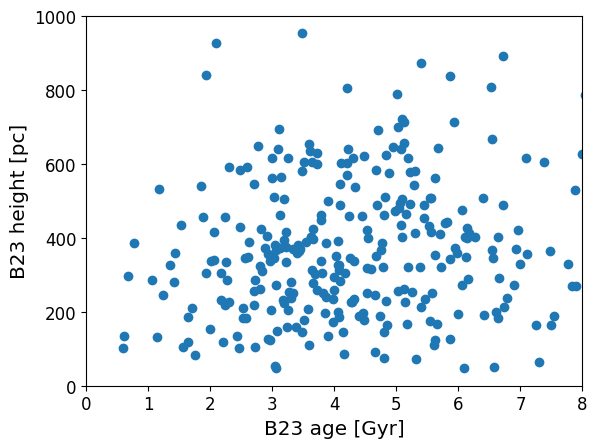

In [14]:
plt.scatter(k2_stars['iso_age'], k2_stars['zmax']*1000)
plt.ylim([0, 1000])
plt.xlim([0,8])
plt.xlabel('B23 age [Gyr]')
plt.ylabel('B23 height [pc]')
plt.show()

0      5.008
1      3.646
2      5.865
3      3.633
4      5.033
       ...  
337    4.095
338    3.628
339    6.549
340    3.474
341    2.200
Name: iso_age, Length: 342, dtype: float64
0      819.129868
1      314.431603
2      867.527710
3      570.357996
4      688.784606
          ...    
337    283.742707
338    383.956117
339    395.185597
340    957.028616
341    117.034435
Name: zmax, Length: 342, dtype: float64


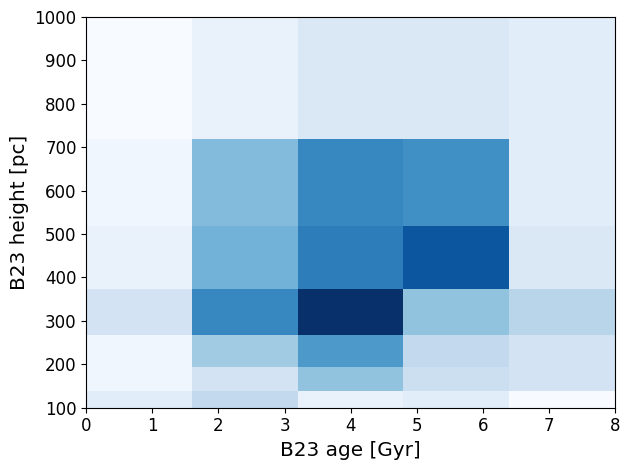

In [149]:
bins2d = [np.linspace(0, 8, 6), np.logspace(2, 3, 8)]

label='B23'
ages = k2_stars['iso_age']
heights = k2_stars['zmax']*1000
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B23':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B23 age [Gyr]')
	plt.ylabel('B23 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_B23.png')
plt.show()

Hmm, not enough stars overall to get a good signal out of the age vs height plot. But what if we bootstrapped a bunch of times? 

(Normally, I'd use simulate_helpers.draw_asymmetrically() out of the box, but the first line of the function pre-supposes Kepler IDs...oops)

In [15]:
def draw_asymmetrically(df, mode_name, err1_name, err2_name, drawn):
    """
    Draw stellar properties with asymmetric errors. 
    This is the generalized version of draw_star_ages(), below
    
    Inputs:
    - df: berger_kepler [Pandas DataFrame]
    - mode_name: name of mode column [string]
    - err1_name: name of err1 column [string]
    - err2_name: name of err2 column [string]
    - drawn: name of new column [string]

    Output:
    - df: berger_kepler_df, now with new column with drawn parameter, "drawn" [Pandas DataFrame]
    """

    # in case df is broken up by planet and not star
    uniques = df
    
    if drawn=='age':
        x = np.linspace(0.5, 13.5, 100)
    elif drawn=='gyro_age':
        x = np.linspace(0.5, 4., 100)
    elif drawn=='stellar_radius':
        x = np.linspace(0.5, 5., 100)
    elif drawn=='stellar_mass':
        x = np.linspace(0.5, 2.5, 100)
    elif drawn=='Teff':
        x = np.linspace(5300, 7500, 1000) # x = np.linspace(3700, 7500, 1000); Z23 did (4000, 6500, 1000)
    elif drawn=='stellar_feh':
        x = np.linspace(-0.5, 0.5, 100)
    elif drawn=='distance':
        x = np.linspace(0, 5000, 1000)
    elif drawn=='planet_radius':
        x = np.linspace(0.5, 10, 100)
    elif drawn=='logg':
        x = np.linspace(3.6, 4.7, 100)

    else: 
        print("Please create a column that is either age, gyro_age, stellar_radius, stellar_mass, distance, planet_radius, stellar_feh, or stellar_teff!")

    """
    TESTING
    print("x: ", x)
    pdf = make_pdf_rows(x, mode, err1, err2)
    pdf = pdf/np.sum(pdf)
    draw = np.around(np.random.choice(x, p=pdf), 2)
    print("draw: ", draw)
    """

    if drawn=='planet_radius':
        df_or_uniques = df
    else:
        df_or_uniques = uniques

    draws = np.ones(len(df_or_uniques))
    for i in range(len(df_or_uniques)):
        mode = df_or_uniques.iloc[i][mode_name]
        err1 = df_or_uniques.iloc[i][err1_name]
        err2 = np.abs(df_or_uniques.iloc[i][err2_name])
        
        #"""
        # symmetric uncertainties
        if err1==err2:
            draw = 0
            while draw <= 0: # make sure the draw is positive
                draw = np.around(np.random.normal(mode, err1), 2)

        # asymmetric uncertainties
        elif err1!=err2:
            pdf = simulate_helpers.make_pdf_rows(x, mode, err1, err2)
            pdf = pdf/np.sum(pdf)

            try:
                draw = 0
                while draw <= 0: # make sure the draw is positive
                    draw = np.around(np.random.choice(x, p=pdf), 2)
            except Exception as e:
                print("EXCEPTION: ", i, pdf, mode, err1, err2)
                print(e)
                break
                continue
        #"""

        """
        ### make all draws the same way, symmetric or asymmetric
        pdf = make_pdf_rows(x, mode, err1, err2)
        pdf = pdf/np.sum(pdf)

        try:
            draw = 0
            while draw <= 0: # make sure the draw is positive
                draw = np.around(np.random.choice(x, p=pdf), 2)
        except Exception as e:
            print("EXCEPTION: ", i, pdf, mode, err1, err2)
            print(e)
            break
        """

        #print(mode, err1, err2, draw)
        draws[i] = draw

    #print(len(df), len(draws), len(uniques))
    df_or_uniques[drawn] = draws

    # break back out into planet rows and forward fill across systems
    df = uniques.merge(df, how='right')
    df[drawn] = df[drawn].fillna(method='ffill')
    
    return df

### adapted from The Cannon project with Aida
def tighter_cull(comparison_df, comparison_teff, comparison_logg):

    comparison_df = comparison_df.loc[((comparison_logg<4.4) & (comparison_teff<6300))]
    comparison_df = comparison_df.loc[((comparison_logg>3.4) & (comparison_teff>5300))]

    return comparison_df


In [16]:
k2_stars_bootstrapped = pd.DataFrame()

for i in tqdm(range(30)):
	k2_stars_temp = draw_asymmetrically(k2_stars, 'iso_age', 'iso_age_err1', 'iso_age_err2', 'age')
	k2_stars_temp = draw_asymmetrically(k2_stars, 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'Teff')
	k2_stars_temp = draw_asymmetrically(k2_stars, 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'logg')
	# k2_stars_temp = draw_asymmetrically(k2_stars, 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'stellar_feh')
	k2_stars_bootstrapped = pd.concat([k2_stars_bootstrapped, k2_stars_temp])



100%|██████████| 30/30 [00:04<00:00,  7.00it/s]


Cull bootstrapped B23 K2 sample, to keep logg, Teff, and magnitudes within reasonable bounds, in prep for matched sampling.

In [17]:
print(len(k2_stars_bootstrapped))
k2_stars_bootstrapped = k2_stars_bootstrapped.loc[((k2_stars_bootstrapped['logg']<4.7) & (k2_stars_bootstrapped['logg']>3.6))]
k2_stars_bootstrapped = k2_stars_bootstrapped.loc[((k2_stars_bootstrapped['Teff']<6500) & (k2_stars_bootstrapped['Teff']>4900))] # this is redundant? no, here we remove post Kraft break stars
print(len(k2_stars_bootstrapped))


10260
9512


0      6.80
1      6.02
2      5.62
3      4.44
4      6.02
       ... 
337    6.67
338    3.65
339    8.12
340    3.39
341    1.81
Name: age, Length: 9516, dtype: float64
0      819.129868
1      314.431603
2      867.527710
3      570.357996
4      688.784606
          ...    
337    283.742707
338    383.956117
339    395.185597
340    957.028616
341    117.034435
Name: zmax, Length: 9516, dtype: float64


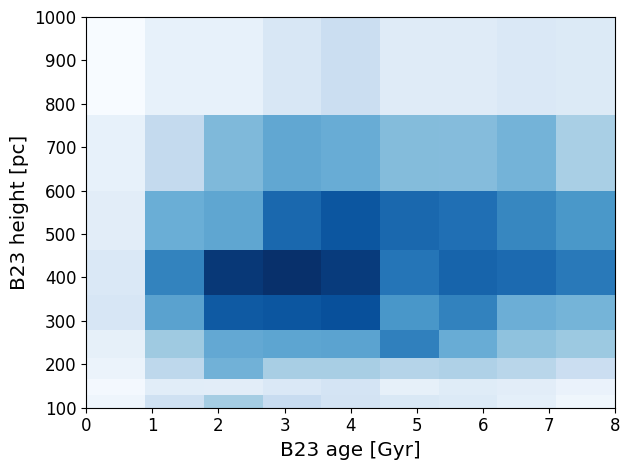

In [377]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='B23'
ages = k2_stars_bootstrapped['age']
heights = k2_stars_bootstrapped['zmax']*1000
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B23':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B23 age [Gyr]')
	plt.ylabel('B23 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_B23_bootstrapped.png')
plt.show()

#### 3D positions

Convert RAs and Decs of K2 fields to b

In [94]:
from astropy.coordinates import SkyCoord, Galactic

ra4 = 59.076
dec4 = 18.661

def convert_ra_dec_to_b(ra, dec):
	# Create a SkyCoord object in the ICRS (equatorial) frame
	# ICRS is the standard J2000 equatorial system assumed by default
	c_icrs = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')

	# Transform the coordinates to the Galactic frame
	c_galactic = c_icrs.transform_to(Galactic())
	# or use the shorthand attribute access:
	# c_galactic = c_icrs.galactic

	# The Galactic latitude 'b' is the angle from the Galactic midplane (b=0)
	b = c_galactic.b * u.degree
	
	return np.abs(b.value)

def ra_dec_to_b_l(ra, dec):
	c_icrs = SkyCoord(ra=ra, dec=dec, frame='icrs', unit='deg')

	# Transform the coordinates to the Galactic frame
	c_galactic = c_icrs.transform_to(Galactic())

	# The Galactic latitude 'b' is the angle from the Galactic midplane (b=0)
	b = c_galactic.b 
	l = c_galactic.l 

	return b, l

def degrees_to_radians(deg):
    return deg*np.pi/180

def dist_k2_to_height(d, b):
    """
    K2 fields have variable inclinations, so we need a second parameter, b, to do trigonometry.

    Inputs:
    - d: distance, in pc
    - b: inclination from Galactic midplane, in deg

    Output:
    - h: height off the Galactic midplane, in pc
    """

    incl = degrees_to_radians(b)
    h = d * np.sin(incl)

    return h

b4 = convert_ra_dec_to_b(ra4, dec4)
bs = []
for i in range(19):
    bs.append(convert_ra_dec_to_b(ras[i], decs[i]))

k2_pointings = dict({'campaign': campaigns, 'ra': ras, 'dec': decs, 'b': bs})
print(k2_pointings)

{'campaign': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]), 'ra': [173.93961, 246.1264, 336.66534641439, 59.0759116, 130.1576478, 204.8650344, 287.82850661, 16.3379975, 270.3544823, 186.779443, 260.3880064, 351.6588124, 72.7971166, 160.6824762, 233.617573, 133.7099689, 202.5496152, 130.161017, 347.2590265], 'dec': [1.4172989, -22.4473, -11.096663792177, 18.6605794, 16.829614, -11.2953585, -23.36001815, 5.2623459, -21.7798098, -4.0271572, -23.9759578, -5.1023328, 20.7870759, 6.8509316, -20.0792397, 18.5253931, -7.7210759, 16.8278629, -4.2027029], 'b': [58.531292937220314, 18.532959446605993, 52.42647045809778, 25.947332351078384, 31.51387163024061, 49.84903553228032, 14.570462204991587, 57.43518020338808, 0.5592168377172165, 58.29587273157315, 7.211487713852137, 60.11396589334712, 14.77267573551696, 53.350902824912026, 28.464777359996905, 35.2829262192038, 53.90825186787161, 31.51620958465847, 56.49896205637861]}


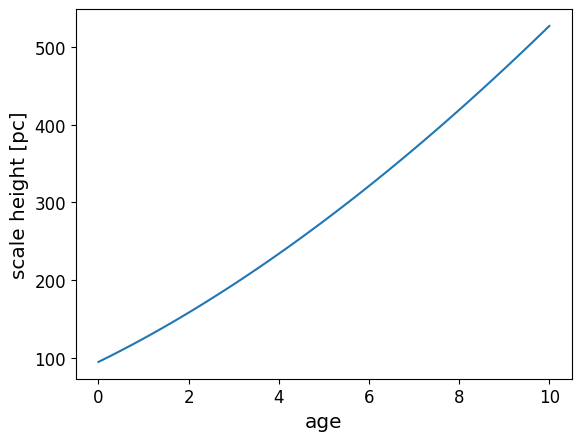

In [95]:
def scale_height_trilegal(t):
	"""
	Draw TRILEGAL scale height-age relation, to compare to empirical Kepler kinematic heating rate

	Args:
		t (float): age [Gyr]

	"""

	z0 = 94.7
	alpha = 1.6666
	t0 = 5.55

	h = z0 * (1 + t/t0)**alpha

	return h

t_linspace = np.linspace(0, 10, 100)
h_linspace = scale_height_trilegal(t_linspace)
plt.plot(t_linspace, h_linspace)
plt.ylabel('scale height [pc]')
plt.xlabel('age')
plt.show()

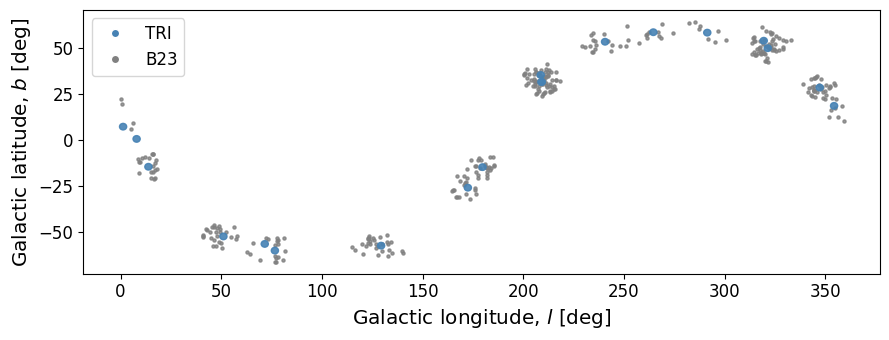

In [96]:
from matplotlib.lines import Line2D

# TRI
tri_k2_bs, tri_k2_ls = ra_dec_to_b_l(ras, decs)

fig, ax = plt.subplots(figsize=(9, 3.5))
for i in range(19):
    center = (tri_k2_ls[i].value, tri_k2_bs[i].value)
    
	# draw circle of radius sqrt(10), since the TRILEGAL queries have a window of 10 sq deg
    if i==0:
        circle = plt.Circle(center, np.sqrt(10/np.pi), alpha=0.9, color='steelblue', zorder=100, label='TRI')
    else:
        circle = plt.Circle(center, np.sqrt(10/np.pi), alpha=0.9, color='steelblue', zorder=100)

	# Add the circle to the axes
    ax.add_patch(circle)

# B23
k2_bs, k2_ls = ra_dec_to_b_l(k2_stars['ra'], k2_stars['dec'])

plt.scatter(k2_ls, k2_bs, label='B23', s=5, alpha=0.8, color='gray')

obj1 = Line2D([], [], color="white", marker='o', markerfacecolor="steelblue")
obj2 = Line2D([], [], color="white", marker='o', markerfacecolor="gray")
plt.legend((obj1, obj2), ('TRI', 'B23'))

plt.xlabel(r'Galactic longitude, $l$ [deg]')
plt.ylabel(r'Galactic latitude, $b$ [deg]')
plt.tight_layout()
plt.savefig(path+'plots/k2/pointings.png')
plt.show()


#### actual parameter draws for TRILEGAL

In [101]:
k2_stars.to_csv(path+'data/k2/k2_stars.csv')

B23 didn't have kepmag. So I went to Exoplanet Archive's Table Access Protocol (TAP; https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html#k2) and queried all K2 targets there. Don't say I didn't do nothin

In [102]:
k2candidates = pd.read_csv(path+'data/k2/k2candidates.csv', sep=',')

In [103]:
k2candidates.head()

,epic_number,tm_name,k2_campaign_str,k2_type,rastr,decstr,k2_propid,k2_dist,k2_disterr1,k2_disterr2,...,k2_mass,k2_masserr1,k2_masserr2,k2_kepmag,k2_kepmagerr,k2_kepmagflag,k2_vjmag,k2_vjmagerr,k2_kmag,k2_kmagerr
0,60018365,2MASS J23391492-0556597,E,NaN,23h39m14.93s,-05d56m59.7s,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.12,NaN,NaN,NaN,NaN,8.751,0.019
1,60018369,2MASS J23550014-0224072,E,NaN,23h55m00.15s,-02d24m07.1s,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.14,NaN,NaN,NaN,NaN,8.975,0.021
2,60018371,2MASS J23572163+0041200,E,NaN,23h57m21.64s,+00d41m19.9s,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.14,NaN,NaN,NaN,NaN,8.632,0.027
3,60018372,2MASS J23392604-0328341,E,NaN,23h39m26.04s,-03d28m34.0s,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.15,NaN,NaN,NaN,NaN,8.955,0.023
4,60018374,2MASS J00035057+0046323,E,NaN,00h03m50.59s,+00d46m32.4s,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.15,NaN,NaN,NaN,NaN,8.928,0.023


In [107]:
k2_stars_candidates = pd.merge(k2_stars, k2candidates[['epic_number','k2_kmag','k2_kmagerr']], left_on='EPIC', right_on='epic_number')

In [ ]:
import os
import re

stem = 'data/k2/trilegal/campaign' 
filenames = os.listdir(path+'data/k2/trilegal/')
tri_k2 = pd.DataFrame()
for i in range(len(filenames)):
	
	# there's a test file in this directory. skip it.
	if 'test' in filenames[i]:
		continue

	#temp_k2 = pd.read_csv(path+stem+f'{i+1}.dat.txt', sep='\s+')
	temp_k2 = pd.read_csv(path+'data/k2/trilegal/'+filenames[i], sep='\s+')
	temp_k2.dropna(subset=['logAge','m2/m1'], inplace=True)

	# remove end lines from TRILEGAL, if applicable
	try:
		temp_k2 = temp_k2[~temp_k2['logAge'].str.contains('normally', na=False)]
	except:
		pass

	# based on campaign, grab b of the pointing
	#temp_campaign = int(i)
	temp_campaign = int(re.search('campaign(.+?).dat', filenames[i]).group(1))
	temp_b = k2_pointings['b'][temp_campaign-1]
	#temp_b = k2_pointings[k2_pointings['campaign']==temp_campaign]['b']

	# add height column, introducing a spread of 0.05 dex based on TRILEGAL distance modulus bin size
	temp_k2['distance'] = simulate_helpers.distance_modulus_to_distance(temp_k2['m-M0'], perturb=True)
	temp_k2['height'] = dist_k2_to_height(temp_k2['distance'], temp_b)

	# add column for campaign and for whether it's high or low Galactic latitude
	temp_k2['campaign'] = temp_campaign

	tri_k2 = pd.concat([tri_k2, temp_k2])

print("initial TRI: ", len(tri_k2))

# remove binaries
tri_k2 = tri_k2[tri_k2['m2/m1']==0]
print("cut binaries: ", len(tri_k2))

# unlog Teff. keep FGK dwarfs only
tri_k2['Teff'] = 10**tri_k2['logTe'].astype(float)
#tri_k2 = tri_k2.loc[(tri_k2['Teff'] <= 6500) & (tri_k2['Teff'] >= 5300)] # keep only F and G dwarfs, pre-Kraft break
tri_k2 = tri_k2.loc[(tri_k2['Teff'] <= np.max(k2_stars_candidates['Teff'])) & (tri_k2['Teff'] >= np.min(k2_stars_bootstrapped['Teff']))]
print("Teff cut: ", len(tri_k2))
print("max Teff: ", np.max(k2_stars_bootstrapped['Teff']))
print("min Teff: ", np.min(k2_stars_bootstrapped['Teff']))

# calculate stellar radius
tri_k2['stellar_radius'] = simulate_helpers.stellar_radius_stefan_boltzmann(10**tri_k2['logTe'], 10**tri_k2['logL'])

# remove giant based on B20 prescription
tri_k2['logR'] = np.log10(tri_k2['stellar_radius'])
tri_k2['is_giant'] = np.where(tri_k2['logR'] >= 0.00035*(tri_k2['Teff'] - 4500) + 0.15, True, False)
tri_k2 = tri_k2.loc[tri_k2['is_giant'] == False]
print("cut giants: ", len(tri_k2))

# remove poofy stars
tri_k2 = tri_k2.loc[(tri_k2['logg']<4.7) & (tri_k2['logg']>4.)]
print("logg cut: ", len(tri_k2))

# TRILEGAL logAge bin size is 0.02, so let's introduce a spread of that size; note from Luke Bouma (https://github.com/lgbouma/gyrojo/blob/main/gyrojo/trilegal.py#L92-L108)
eps = np.random.normal(loc=0, scale=0.02, size=len(tri_k2))
tri_k2['logAge'] = tri_k2['logAge'].astype(float)
tri_k2['logAge'] += eps
tri_k2['age'] = 10**tri_k2['logAge'].astype(float) / 1e9

# metallicity cuts
tri_k2 = tri_k2.loc[tri_k2['[M/H]'].astype(float)>=-0.25] # this is different from Fe/H cut for B23, but we only have apples v oranges
tri_k2 = tri_k2.loc[tri_k2['[M/H]'].astype(float)<=0.25]
print("metallicity cut: ", len(tri_k2))

# age cut for uniformity
tri_k2 = tri_k2.loc[tri_k2['age'] <= 12.]
print("age cut: ", len(tri_k2))

# make an additional cut on Kepler magnitude. actually I can't do that here because B23 doesn't have Kepmag
#tri_k2 = tri_k2.loc[(tri_k2['Kepler'] <= np.max(k2_stars_bootstrapped['kepmag'])) & (tri_k2['Kepler'] >= np.min(k2_stars_bootstrapped['kepmag']))] 
#print("kepmag cut: ", len(tri_k2))
#print("min kepmag: ", np.min(k2_stars_bootstrapped['kepmag']))
#print("max kepmag: ", np.max(k2_stars_bootstrapped['kepmag']))

# extrapolate CDPP based on Zink+20
#my_k2 = simulate_helpers.kepmag_to_cdpp_vectorized(k2_stars, my_k2) # cdpp distribution is similar to B20 sample

tri_k2 = tri_k2.reset_index()
tri_k2


initial TRI:  842457
cut binaries:  496124
Teff cut:  123197
max Teff:  7410.610610610611
min Teff:  4873.473473473474
cut giants:  90761
logg cut:  80537
metallicity cut:  49777
age cut:  49777


,index,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,...,Ks,Mact,distance,height,campaign,Teff,stellar_radius,logR,is_giant,age
0,23,1,8.633001,-0.19,0.91875,-0.268,3.739,4.570,8.670706,0.038,...,12.509,0.919,542.177165,283.398703,5,5482.769649,0.815993,-0.088314,False,0.429537
1,43,1,8.855823,-0.13,1.36216,0.603,3.844,4.290,7.167643,0.035,...,9.592,1.362,271.349218,141.835587,5,6982.324041,1.371470,0.137186,False,0.717502
2,45,1,8.884355,0.17,1.00134,-0.163,3.740,4.506,7.079848,0.034,...,10.595,1.001,260.597090,136.215396,5,5495.408739,0.916613,-0.037814,False,0.766222
3,52,1,8.894953,-0.07,1.37716,0.611,3.839,4.268,7.054576,0.034,...,9.386,1.377,257.581793,134.639286,5,6902.398038,1.416401,0.151186,False,0.785151
4,54,1,8.886425,0.07,0.85261,-0.489,3.698,4.596,9.263511,0.038,...,13.271,0.853,712.364516,372.356479,5,4988.844875,0.764163,-0.116814,False,0.769884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49772,2940,1,9.937727,-0.05,0.95559,0.041,3.760,4.365,9.493276,0.038,...,12.687,0.956,791.872225,605.266072,6,5754.399373,1.057271,0.024186,False,8.664176
49773,2941,1,9.894522,-0.05,0.87461,-0.242,3.733,4.502,9.983420,0.038,...,13.703,0.875,992.393520,758.534153,6,5407.543229,0.864343,-0.063314,False,7.843712
49774,2942,1,9.891845,-0.05,0.99511,0.181,3.766,4.266,11.311976,0.038,...,14.180,0.995,1829.764264,1398.576934,6,5834.451043,1.208332,0.082186,False,7.795512
49775,2945,1,9.899298,-0.01,1.02301,0.272,3.765,4.180,11.323126,0.038,...,13.939,1.023,1839.184194,1405.777040,6,5821.032178,1.347988,0.129686,False,7.930447


In [ ]:
# split campaigns into low and high Galactic latitudes based on https://archive.stsci.edu/missions-and-data/k2/campaign-fields.html#datepos
low_tri_k2 = tri_k2.loc[tri_k2['campaign'].isin(lows)]
high_tri_k2 = tri_k2.loc[tri_k2['campaign'].isin(highs)]


0       0.225760
1       0.246755
2       0.381928
3       0.600752
4       0.603359
          ...   
7838    7.224021
7839    7.887388
7840    7.998284
7841    7.765550
7842    7.919315
Name: age, Length: 7843, dtype: float64
0        729.198490
1        107.583084
2        624.634615
3        236.620206
4        122.483733
           ...     
7838     948.007579
7839    1110.139146
7840     522.314973
7841     507.655597
7842     512.590043
Name: height, Length: 7843, dtype: float64


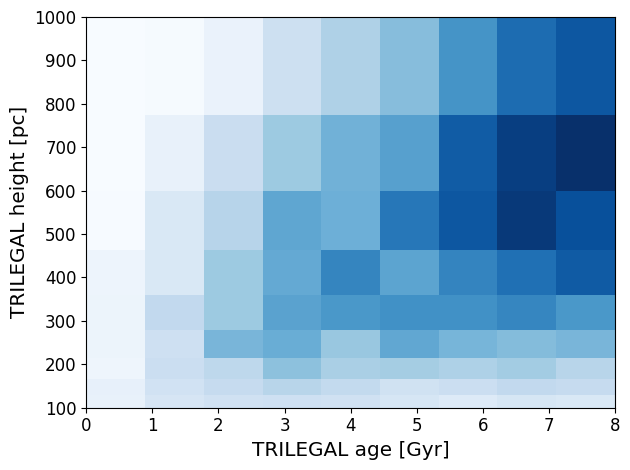

In [ ]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='TRI'
ages = tri_k2['age']
heights = tri_k2['height']
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
	plt.tight_layout()
	plt.savefig(path+'plots/k2/age_vs_height_TRI.png')
	plt.show()


Why are my ages centered so late? Let's first plot a Kiel diagram for both TRI and B23.

(Once again, I must copy-paste psps code because of a single line that pre-supposed I would work with Kepler data forever.)

median Teff:  6011.737374832779
median age:  3.9334630778092166


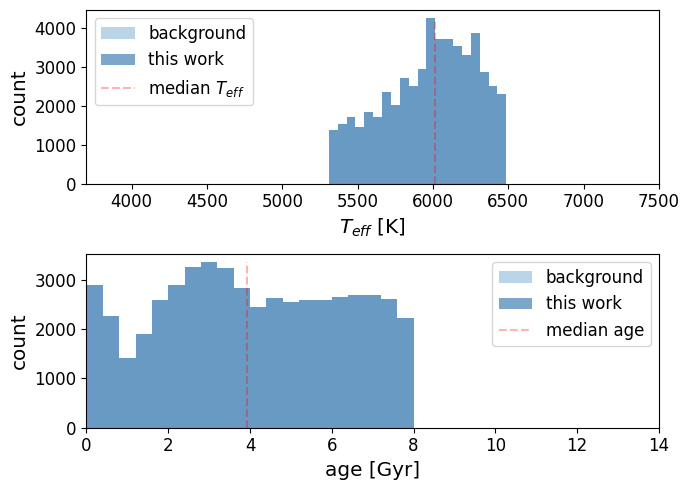

In [25]:
def plot_properties(df, label):

	if label=='TRI':
		df_sub = df.loc[(df['Teff'] >= 5300) & (df['Teff'] <= 7500)] # what we actually use
		df_sub = df_sub.loc[(df_sub['age'] >= 0) & (df_sub['age'] <= 8)]
		teffs = df['Teff']
		ages = df['age']
		teffs_sub = df_sub['Teff']
		ages_sub = df_sub['age']
	elif label=='B23':
		df_sub = df.loc[(df['iso_teff'] >= 5300) & (df['iso_teff'] <= 7500)] # what we actually use
		df_sub = df_sub.loc[(df_sub['iso_age'] >= 0) & (df_sub['iso_age'] <= 8)]
		teffs = df['iso_teff']
		ages = df['iso_age']
		teffs_sub = df_sub['iso_teff']
		ages_sub = df_sub['iso_age']

	#fig, axes = plt.subplots(figsize=(7,5))
	fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 5))

	### TEFF
	#ax1 = plt.subplot2grid((2,1), (0,0))
	ax1.hist(teffs, bins=20, alpha=0.3, label='background') # background
	bins, edges, patches = ax1.hist(teffs_sub, bins=20, alpha=0.7, color='steelblue', label='this work') # what we actually use
	ax1.set_ylabel("count")
	ax1.set_xlabel(r"$T_{eff}$ [K]")
	# plot vertical red line through median Teff

	ax1.plot([np.median(teffs_sub), np.median(teffs_sub)], 
			[0,np.max(bins)], color='r', alpha=0.3, linestyle='--', label=r'median $T_{eff}$')
	ax1.set_xlim([3700, 7500])
	ax1.legend()

	### AGE
	#ax2 = plt.subplot2grid((2,1), (1,0))
	ax2.hist(ages, bins=20, alpha=0.3, label='background') # background
	bins, edges, patches = ax2.hist(ages_sub, bins=20, alpha=0.7, color='steelblue', label='this work') # what we actually use
	# plot vertical red line through median age 
	ax2.plot([np.median(ages_sub), np.median(ages_sub)], 
			[0,np.max(bins)], color='r', alpha=0.3, linestyle='--', label='median age')
	ax2.set_ylabel("count")
	ax2.set_xlabel("age [Gyr]")
	ax2.set_xlim([0, 14])
	ax2.legend()
	fig.tight_layout()
	plt.savefig(path+'plots/k2/sample_properties_tri.png')

	print("median Teff: ", np.median(teffs_sub))
	print("median age: ", np.median(ages_sub))


plot_properties(tri_k2, label='TRI')

median Teff:  6011.737374832779
median age:  3.9334630778092166


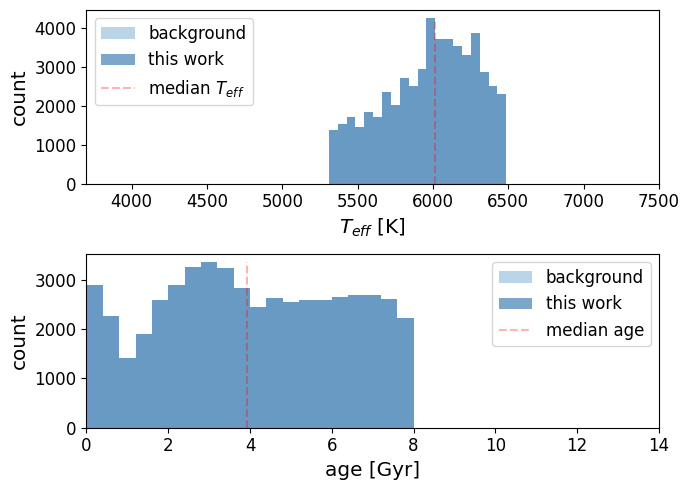

In [26]:
def plot_properties(df, label):

	if label=='TRI':
		df_sub = df.loc[(df['Teff'] >= 5300) & (df['Teff'] <= 7500)] # what we actually use
		df_sub = df_sub.loc[(df_sub['age'] >= 0) & (df_sub['age'] <= 8)]
		teffs = df['Teff']
		ages = df['age']
		teffs_sub = df_sub['Teff']
		ages_sub = df_sub['age']
	elif label=='B23':
		df_sub = df.loc[(df['iso_teff'] >= 5300) & (df['iso_teff'] <= 7500)] # what we actually use
		df_sub = df_sub.loc[(df_sub['iso_age'] >= 0) & (df_sub['iso_age'] <= 8)]
		teffs = df['iso_teff']
		ages = df['iso_age']
		teffs_sub = df_sub['iso_teff']
		ages_sub = df_sub['iso_age']

	### VISUALIZE TRILEGAL SAMPLE PROPERTIES, FOR PAPER FIGURE
	#teff_hist, teff_bin_edges = np.histogram(teffs, bins=50)
	#print("Teff peak: ", teff_bin_edges[np.argmax(teff_hist)])
	#age_hist, age_bin_edges = np.histogram(ages, bins=50)
	#print("age peak: ", age_bin_edges[np.argmax(age_hist)])

	#fig, axes = plt.subplots(figsize=(7,5))
	fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 5))

	### TEFF
	#ax1 = plt.subplot2grid((2,1), (0,0))
	ax1.hist(teffs, bins=20, alpha=0.3, label='background') # background
	bins, edges, patches = ax1.hist(teffs_sub, bins=20, alpha=0.7, color='steelblue', label='this work') # what we actually use
	ax1.set_ylabel("count")
	ax1.set_xlabel(r"$T_{eff}$ [K]")
	# plot vertical red line through median Teff

	ax1.plot([np.median(teffs_sub), np.median(teffs_sub)], 
			[0,np.max(bins)], color='r', alpha=0.3, linestyle='--', label=r'median $T_{eff}$')
	ax1.set_xlim([3700, 7500])
	ax1.legend()

	### AGE
	#ax2 = plt.subplot2grid((2,1), (1,0))
	ax2.hist(ages, bins=20, alpha=0.3, label='background') # background
	bins, edges, patches = ax2.hist(ages_sub, bins=20, alpha=0.7, color='steelblue', label='this work') # what we actually use
	# plot vertical red line through median age 
	ax2.plot([np.median(ages_sub), np.median(ages_sub)], 
			[0,np.max(bins)], color='r', alpha=0.3, linestyle='--', label='median age')
	ax2.set_ylabel("count")
	ax2.set_xlabel("age [Gyr]")
	ax2.set_xlim([0, 14])
	ax2.legend()
	fig.tight_layout()
	plt.savefig(path+'plots/k2/sample_properties_tri.png')

	print("median Teff: ", np.median(teffs_sub))
	print("median age: ", np.median(ages_sub))


plot_properties(tri_k2, label='TRI')

<Figure size 800x800 with 0 Axes>

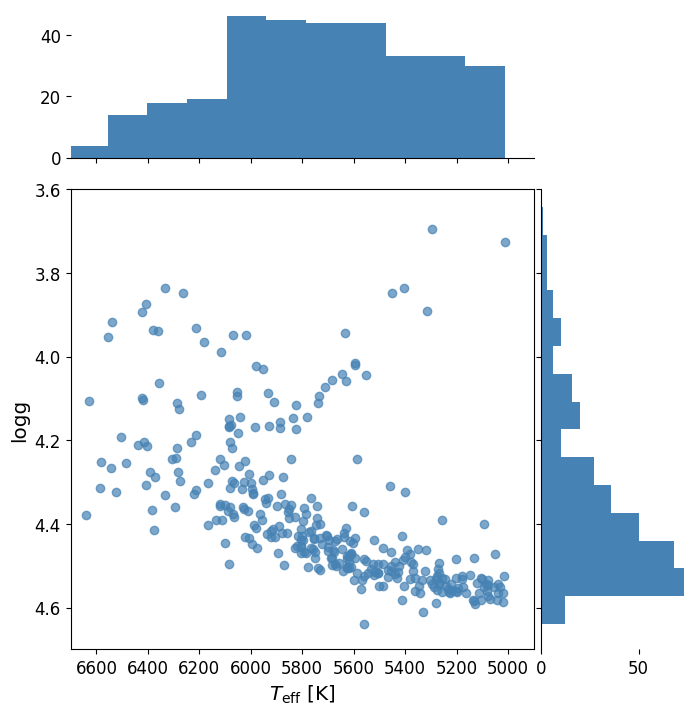

In [265]:
from matplotlib.gridspec import GridSpec

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1:4, 0:3])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.03, pos.width, pos.height])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

ax_scatter.scatter(k2_stars['iso_teff'], k2_stars['iso_logg'], alpha=0.7, c='steelblue')

# histograms
ax_histx.hist(k2_stars['iso_teff'], bins=20, color="steelblue")
ax_histy.hist(k2_stars['iso_logg'], bins=20, orientation='horizontal', color="steelblue")
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K]")
ax_scatter.set_ylabel('logg')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
ax_scatter.set_xlim([6700, 4900])
ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label=r'Cannon model reduced $\chi^2$ fit')
plt.tight_layout()
plt.savefig(path+'plots/k2/kiel_b23.png')
plt.show()

<Figure size 800x800 with 0 Axes>

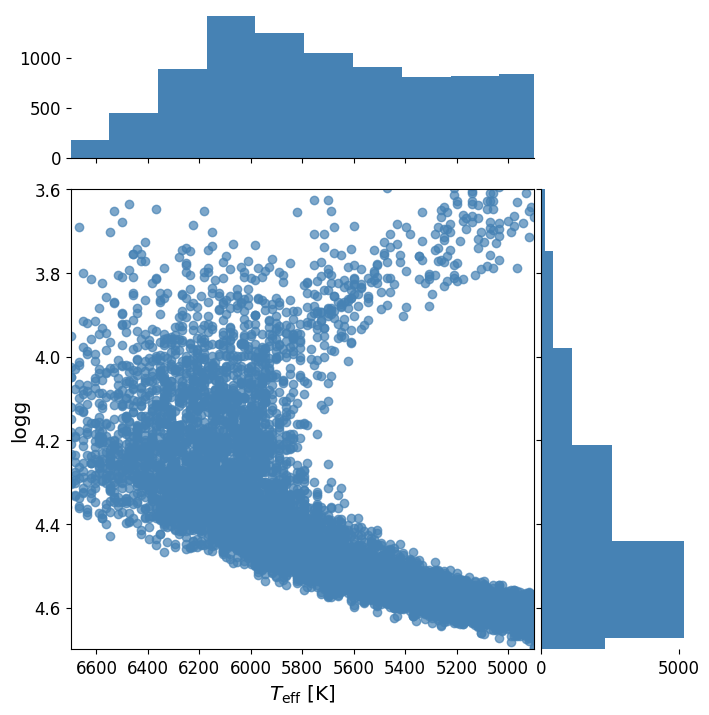

In [266]:
from matplotlib.gridspec import GridSpec

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1:4, 0:3])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.03, pos.width, pos.height])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

ax_scatter.scatter(tri_k2['Teff'], tri_k2['logg'], alpha=0.7, c='steelblue')

# histograms
ax_histx.hist(tri_k2['Teff'], bins=20, color="steelblue")
ax_histy.hist(tri_k2['logg'], bins=20, orientation='horizontal', color="steelblue")
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K]")
ax_scatter.set_ylabel('logg')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
ax_scatter.set_xlim([6700, 4900])
ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label=r'Cannon model reduced $\chi^2$ fit')
plt.tight_layout()
plt.savefig(path+'plots/k2/kiel_tri_b23.png')
plt.show()

In [192]:
k2_stars.columns

Index(['id_starname', 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'iso_logg',
       'iso_logg_err1', 'iso_logg_err2', 'iso_feh', 'iso_feh_err1',
       'iso_feh_err2', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'iso_age_err1', 'iso_age_err2', 'iso_dis', 'iso_dis_err1',
       'iso_dis_err2', 'iso_avs', 'EPIC', 'dr3_source_id', 'bpmag',
       'bpmag_err', 'rpmag', 'rpmag_err', 'parallax_x', 'parallax_err', 'feh',
       'feh_err', 'feh_prov', 'ruwe', 'SOURCE_ID', 'ra', 'dec', 'parallax_y',
       'pmra', 'pmdec', 'radial_velocity', 'ra_error', 'dec_error',
       'parallax_error', 'pmra_error', 'pmdec_error', 'radial_velocity_error',
       'parallax', 'zmax'],
      dtype='object')

In [193]:
tri_k2.columns

Index(['index', '#Gc', 'logAge', '[M/H]', 'm_ini', 'logL', 'logTe', 'logg',
       'm-M0', 'Av', 'm2/m1', 'mbol', 'Kepler', 'g', 'r', 'i', 'z',
       'DDO51_finf', 'J', 'H', 'Ks', 'Mact', 'distance', 'height', 'Teff',
       'age', 'stellar_radius'],
      dtype='object')

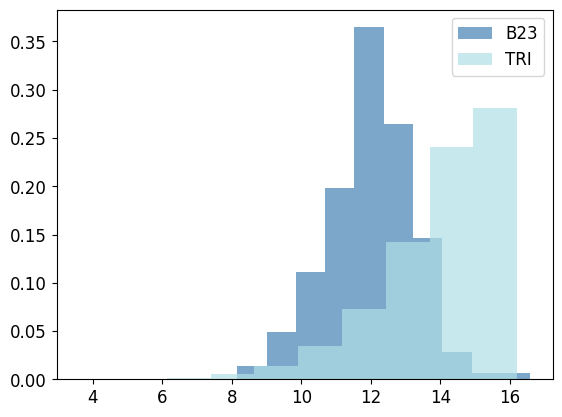

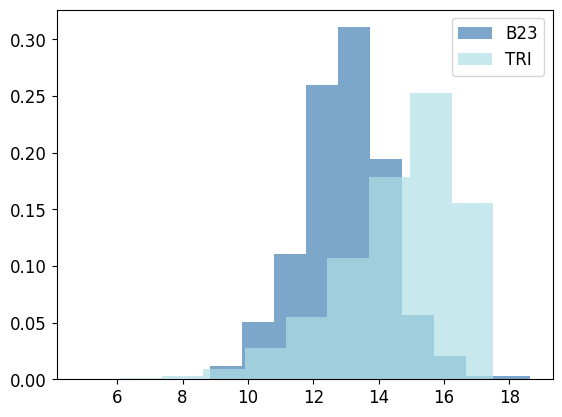

In [356]:
plt.hist(k2_stars['rpmag'], label='B23', alpha=0.7, color='steelblue', density=True)
plt.hist(tri_k2['r'], label='TRI', alpha=0.7, color='powderblue', density=True)
plt.legend()
plt.show()

plt.hist(k2_stars['bpmag'], label='B23', alpha=0.7, color='steelblue', density=True)
plt.hist(tri_k2['g'], label='TRI', alpha=0.7, color='powderblue', density=True)
plt.legend()
plt.show()

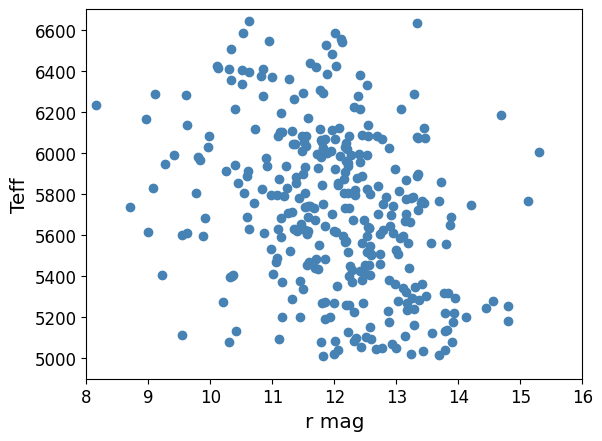

In [269]:
plt.scatter(k2_stars['rpmag'], k2_stars['iso_teff'], label='B23', color='steelblue')
plt.xlabel('r mag')
plt.ylabel('Teff')
plt.xlim([8, 16])
plt.ylim([4900, 6700])
#plt.scatter(tri_k2['r'], tri_k2['Teff'], label='TRI', color='powderblue')
plt.show()

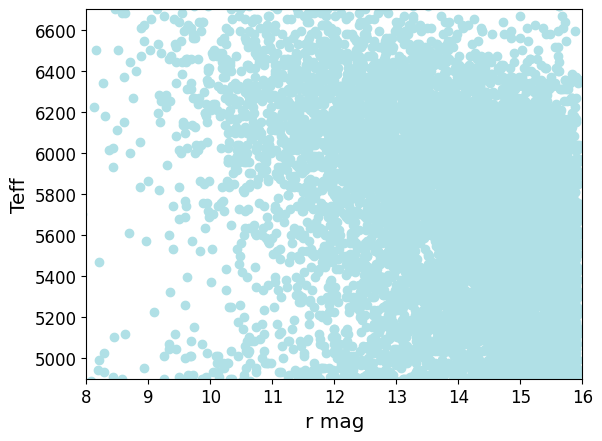

In [270]:
plt.scatter(tri_k2['r'], tri_k2['Teff'], label='TRI', color='powderblue')
plt.xlabel('r mag')
plt.ylabel('Teff')
plt.xlim([8, 16])
plt.ylim([4900, 6700])
plt.show()

In [354]:
from astroquery.utils.tap.core import TapPlus

# Correct MAST TAP endpoint
tap = TapPlus(url="https://mast.stsci.edu/tap-server/tap")

# Example query: select some EPIC columns with filters
query = """
SELECT epic_number, ra, dec, kepmag, teff
FROM mast.epic.epic
WHERE kepmag < 15
  AND teff BETWEEN 5000 AND 6000
"""

# Run asynchronously (safer for large tables)
job = tap.launch_job_async(query)
table = job.get_results()


table

HTTPError: Not Found

^this was a failed attempt to query K2 data to get Kepler mags. I decided to just use red and blue mags. See directly below.

I must apply matched sampling to TRI K2 to get it to match B23 K2.

B23 don't provide Kepler magnitudes -- only blue and red magnitudes. But they sandwich the Kepler broadband mag range, so let's match to Teff, logg, blue, and red mags

In [448]:
tri_k2

,index,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,...,H,Ks,Mact,distance,height,Teff,age,stellar_radius,rpmag,bpmag
0,23,1,8.660925,-0.19,0.91875,-0.268,3.739,4.570,8.717488,0.038,...,12.560,12.509,0.919,553.984499,289.570456,5482.769649,0.458063,0.815993,14.078,14.643
1,45,1,8.841865,0.17,1.00134,-0.163,3.740,4.506,7.077373,0.034,...,10.647,10.595,1.001,260.300206,136.060213,5495.408739,0.694808,0.916613,12.134,12.731
2,54,1,8.909601,0.07,0.85261,-0.489,3.698,4.596,9.166109,0.038,...,13.340,13.271,0.853,681.117078,356.023288,4988.844875,0.812084,0.764163,15.182,15.959
3,56,1,8.871934,0.37,1.21172,0.262,3.786,4.351,6.836277,0.033,...,9.650,9.614,1.212,232.946099,121.762086,6109.420249,0.744619,1.209724,10.781,11.200
4,71,1,9.039704,-0.01,0.94095,-0.249,3.734,4.542,8.150389,0.037,...,12.026,11.972,0.941,426.655886,223.015156,5420.008904,1.095730,0.853466,13.573,14.173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59831,2928,1,9.901121,-0.15,1.03661,0.350,3.776,4.152,12.028251,0.038,...,14.565,14.527,1.037,2544.780216,1945.098055,5970.352866,7.963814,1.401800,15.814,16.226
59832,2935,1,9.885650,-0.09,0.99496,0.187,3.769,4.273,10.362176,0.038,...,13.229,13.189,0.995,1181.503910,903.080330,5874.893525,7.685102,1.200014,14.519,14.962
59833,2939,1,9.888531,-0.07,0.89187,-0.177,3.742,4.478,9.999886,0.038,...,13.649,13.599,0.892,999.947638,764.308129,5520.774393,7.736259,0.893689,15.139,15.700
59834,2942,1,9.894977,-0.05,0.99511,0.181,3.766,4.266,11.322057,0.038,...,14.221,14.180,0.995,1838.278556,1405.084817,5834.451043,7.851946,1.208332,15.531,15.990


       index #Gc    logAge  [M/H]    m_ini   logL  logTe   logg      m-M0  \
20199   3305   1  9.679853   0.03  1.11580  0.327  3.779  4.219  7.798199   
21321    689   1  9.655221   0.05  1.16876  0.385  3.781  4.189  7.845556   
41263    853   1  9.700759  -0.05  1.12122  0.329  3.781  4.228  7.788204   
23921   1849   1  9.585340  -0.01  1.17293  0.397  3.783  4.188  8.109882   
31385    588   1  9.512730   0.19  1.22635  0.408  3.777  4.173  7.962135   
...      ...  ..       ...    ...      ...    ...    ...    ...       ...   
43105      0   1  7.268265   0.21  1.19615  0.189  3.780  4.392  5.984461   
26998   1995   1  9.855022  -0.09  0.99071  0.101  3.770  4.357  5.717984   
28751   1526   1  9.846176  -0.23  1.01486  0.234  3.782  4.285  6.219821   
41410   1553   1  9.881056  -0.33  0.94239  0.111  3.779  4.365  5.944148   
31302     81   1  8.937603   0.11  1.15636  0.188  3.782  4.385  5.789886   

          Av  ...      Ks   Mact    distance      height  campaign  \
20199

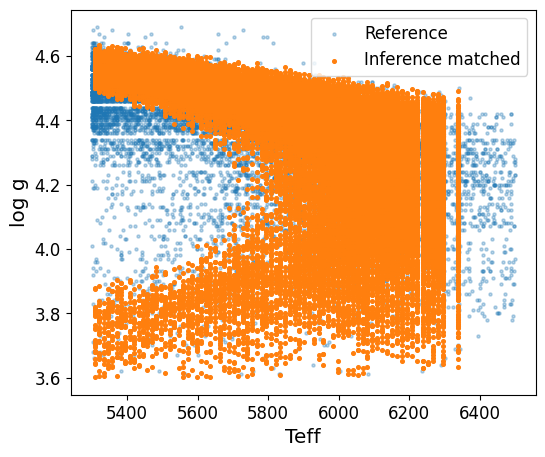

,index,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,...,Ks,Mact,distance,height,campaign,Teff,age,stellar_radius,rpmag,bpmag
0,23,1,8.652182,-0.19,0.91875,-0.268,3.739,4.570,8.585947,0.038,...,12.509,0.919,521.422055,272.549904,5,5482.769649,0.448933,0.815993,14.078,14.643
1,45,1,8.852050,0.17,1.00134,-0.163,3.740,4.506,7.050150,0.034,...,10.595,1.001,257.057340,134.365151,5,5495.408739,0.711296,0.916613,12.134,12.731
2,56,1,8.862498,0.37,1.21172,0.262,3.786,4.351,6.824166,0.033,...,9.614,1.212,231.650498,121.084869,5,6109.420249,0.728615,1.209724,10.781,11.200
3,71,1,8.966769,-0.01,0.94095,-0.249,3.734,4.542,8.300917,0.037,...,11.972,0.941,457.281326,239.023226,5,5420.008904,0.926337,0.853466,13.573,14.173
4,72,1,8.962748,0.03,1.12594,0.144,3.780,4.413,11.610466,0.038,...,14.620,1.126,2099.390255,1097.361738,5,6025.595861,0.917800,1.085641,15.865,16.277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52413,2935,1,9.897134,-0.09,0.99496,0.187,3.769,4.273,10.267086,0.038,...,13.189,0.995,1130.881665,864.387311,6,5874.893525,7.891027,1.200014,14.519,14.962
52414,2937,1,9.879531,-0.09,1.04085,0.348,3.772,4.140,10.974788,0.038,...,13.503,1.041,1566.598009,1197.426293,6,5915.616342,7.577585,1.424578,14.815,15.247
52415,2941,1,9.881957,-0.05,0.87461,-0.242,3.733,4.502,10.097958,0.038,...,13.703,0.875,1046.144340,799.618493,6,5407.543229,7.620032,0.864343,15.310,15.908
52416,2942,1,9.880109,-0.05,0.99511,0.181,3.766,4.266,11.280175,0.038,...,14.180,0.995,1803.162671,1378.244055,6,5834.451043,7.587683,1.208332,15.531,15.990


In [ ]:
def matched_sampling(reference_df, sample_df):

    sample_df['rpmag'] = sample_df['r']
    sample_df['bpmag'] = sample_df['g']
    
    # normalize variables
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_sample = scaler.fit_transform(sample_df[['Teff','logg','rpmag','bpmag']])
    X_ref    = scaler.transform(reference_df[['Teff','logg','rpmag','bpmag']])

    # fit nearest-neighbor index
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=10) # draw 10x the size of B23 K2  
    nn.fit(X_sample)

    # query neighbors for each reference star
    dist, idx = nn.kneighbors(X_ref)
    matched_idx = idx.flatten()  
    matched_sample = sample_df.iloc[matched_idx]

    return matched_sample

tri_matched_to_b23_k2 = matched_sampling(k2_stars_bootstrapped, tri_k2)
#matched_smapling(k2_stars, tri_k2['Kepler'], tri_k2['Teff'], new_height)
#tri_matched_to_b23_k2 = matched_sampling_kde(k2_stars_bootstrapped, tri_k2)
print(tri_matched_to_b23_k2)

"""
def matched_sampling_kde(reference_df, sample_df):

    import numpy as np
    from sklearn.neighbors import KernelDensity

    # Reference sample
    X_ref = np.vstack([reference_df['Teff'], reference_df['logg']]).T   

    # Inference sample
    X_inf = np.vstack([sample_df['Teff'], sample_df['logg']]).T  

    # fit KDE to reference stars and evaluate
    kde = KernelDensity(
        kernel='gaussian',
        bandwidth=0.1 * np.std(X_ref, axis=0).mean() # bandwidth tries: 
    ).fit(X_ref)

    ref = kde.score_samples(X_ref)   # KDE evaluated on reference
    inf = kde.score_samples(X_inf)   # KDE evaluated on inference sample

    # density threshold
    threshold = np.percentile(ref, 5)

    # filter based on threshold
    mask = inf >= threshold
    X_inf_matched = X_inf[mask]
    matched_sample = sample_df[mask]
    print(matched_sample)

    plt.figure(figsize=(6,5))
    plt.scatter(X_ref[:,0], X_ref[:,1], s=5, label="Reference", alpha=0.3)
    plt.scatter(X_inf_matched[:,0], X_inf_matched[:,1], s=7, label="Inference matched")
    plt.xlabel("Teff")
    plt.ylabel("log g")
    plt.legend()
    plt.show()

    return matched_sample

matched_sampling_kde(k2_stars_bootstrapped, tri_k2)
"""


In [486]:
print(len(tri_matched_to_b23_k2))
print(len(tri_k2))
print(len(k2_stars_bootstrapped))

95160
52423
9516


Index(['index', '#Gc', 'logAge', '[M/H]', 'm_ini', 'logL', 'logTe', 'logg',
       'm-M0', 'Av', 'm2/m1', 'mbol', 'Kepler', 'g', 'r', 'i', 'z',
       'DDO51_finf', 'J', 'H', 'Ks', 'Mact', 'distance', 'height', 'Teff',
       'age', 'stellar_radius', 'rpmag', 'bpmag'],
      dtype='object')


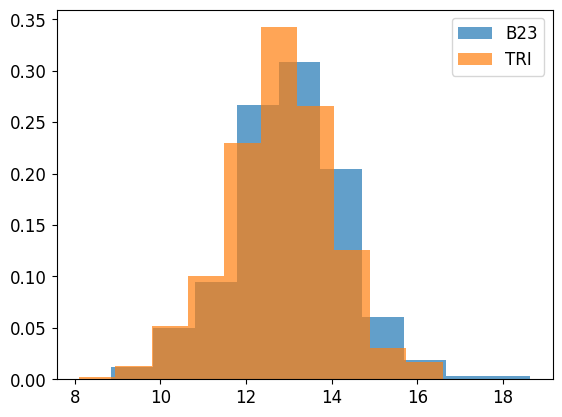

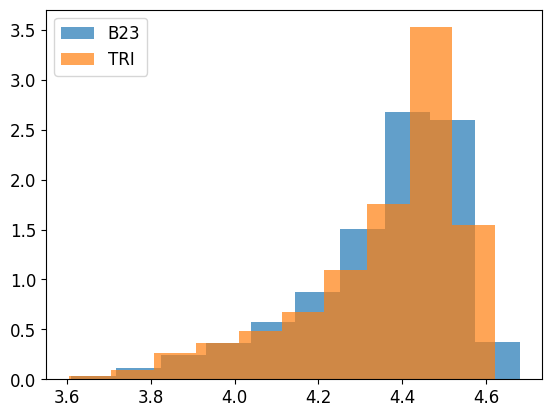

In [480]:
print(tri_matched_to_b23_k2.columns)

plt.hist(k2_stars_bootstrapped['bpmag'], alpha=0.7, label='B23', density=True)
plt.hist(tri_matched_to_b23_k2['bpmag'], alpha=0.7, label='TRI', density=True)
plt.legend()
plt.show()

plt.hist(k2_stars_bootstrapped['logg'], alpha=0.7, label='B23', density=True)
plt.hist(tri_matched_to_b23_k2['logg'], alpha=0.7, label='TRI', density=True)
plt.legend()
plt.show()

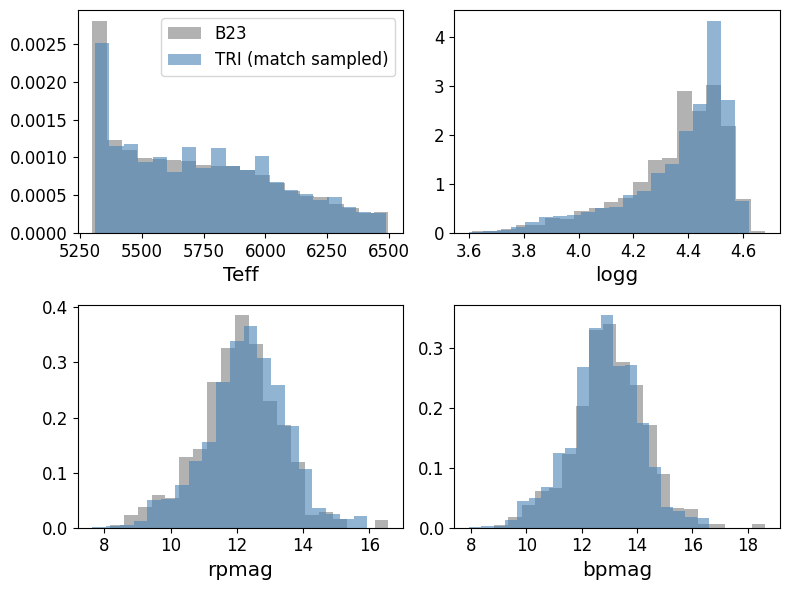

In [484]:
cols = ["Teff", "logg", "rpmag", "bpmag"]

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]

    ax.hist(k2_stars_bootstrapped[col], bins=20, alpha=0.6, label="B23", density=True, color='gray')
    ax.hist(tri_matched_to_b23_k2[col],   bins=20, alpha=0.6, label="TRI (match sampled)",   density=True, color='steelblue')

    ax.set_xlabel(col)
    #ax.set_ylabel()
    if i==0:
        ax.legend()

plt.tight_layout()
plt.savefig(path+'plots/k2/matched_sampling_params.png')
plt.show()

In [494]:
# let's read out datasets 
k2_stars_bootstrapped.to_csv(path+'data/k2/k2_stars_bootstrapped.csv', index=False)
tri_matched_to_b23_k2.to_csv(path+'data/k2/tri_matched_to_b23_k2.csv', index=False)

7064     6.349963
26246    6.715690
6948     5.634974
7115     6.379405
51335    7.249472
           ...   
43103    0.019278
51693    3.616696
31314    0.977777
41479    2.231956
638      7.472534
Name: age, Length: 95160, dtype: float64
7064     255.746517
26246    174.868081
6948     335.277840
7115     222.099576
51335     85.536212
            ...    
43103      1.531595
51693    127.310536
31314     45.362683
41479    143.402921
638       88.395633
Name: height, Length: 95160, dtype: float64


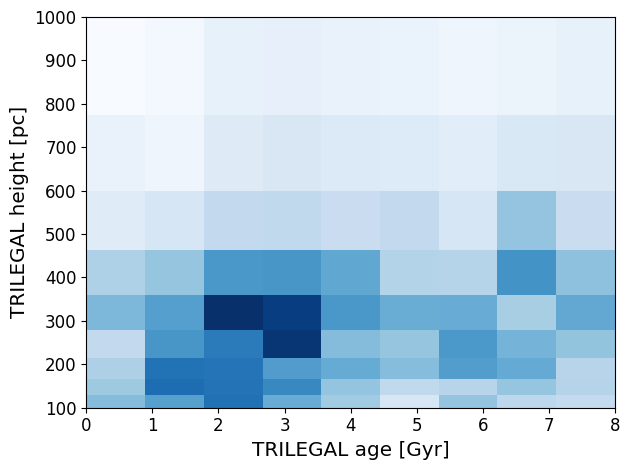

In [485]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='TRI'
ages = tri_matched_to_b23_k2['age']
heights = tri_matched_to_b23_k2['height']
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
	plt.tight_layout()
	plt.savefig(path+'plots/k2/age_vs_height_TRI_match_sampled.png')
	plt.show()


21321    4.520862
23921    3.848926
31385    3.256342
25211    4.082127
26120    6.481459
           ...   
14435    2.150216
43105    0.018547
26998    7.161796
28751    7.017398
31302    0.866169
Name: age, Length: 51051, dtype: float64
21321    162.230961
23921    106.780139
31385    124.351046
25211    185.954822
26120    184.702133
            ...    
14435      1.527443
43105      1.535829
26998     72.758273
28751     44.118818
31302     45.729823
Name: height, Length: 51051, dtype: float64


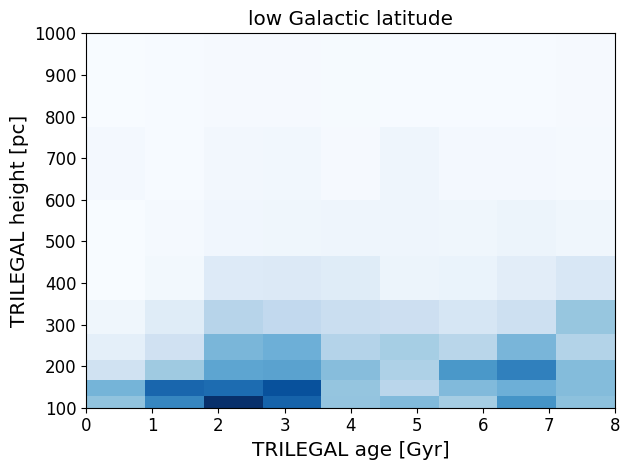

20199    4.784678
41263    5.020643
41589    5.200602
20935    7.194540
41575    4.951607
           ...   
22494    5.347612
27267    2.045968
33872    1.964574
51686    3.757206
41410    7.604239
Name: age, Length: 44069, dtype: float64
20199     305.742383
41263     301.121734
41589     273.260704
20935     286.351900
41575     187.886093
            ...     
22494     974.882993
27267    1177.642745
33872    1118.883111
51686     135.349706
41410     128.804498
Name: height, Length: 44069, dtype: float64


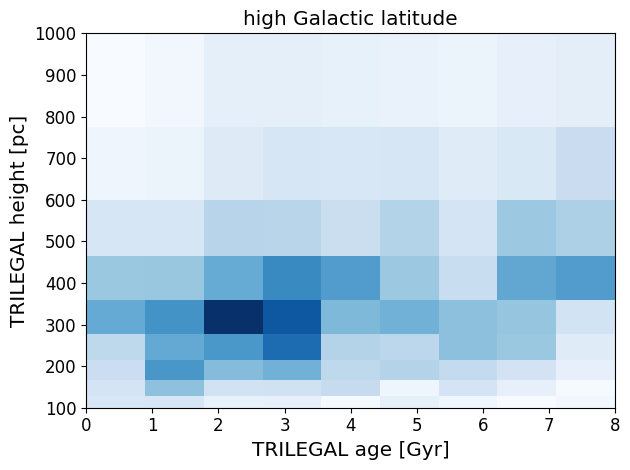

In [44]:
low_tri_k2_matched = tri_matched_to_b23_k2.loc[tri_matched_to_b23_k2['campaign'].isin(lows)]
high_tri_k2_matched = tri_matched_to_b23_k2.loc[tri_matched_to_b23_k2['campaign'].isin(highs)]

bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='TRI'
ages = low_tri_k2_matched['age']
heights = low_tri_k2_matched['height']
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
	plt.title('low Galactic latitude')
	plt.tight_layout()
	#plt.savefig(path+'plots/k2/age_vs_height_TRI_match_sampled.png')
	plt.show()


bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='TRI'
ages = high_tri_k2_matched['age']
heights = high_tri_k2_matched['height']
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
	plt.title('high Galactic latitude')
	plt.tight_layout()
	#plt.savefig(path+'plots/k2/age_vs_height_TRI_match_sampled.png')
	plt.show()

In [413]:
print(k2_pointings['ra'])
print(k2_pointings['dec'])

[173.93961, 246.1264, 336.66534641439, 59.0759116, 130.1576478, 204.8650344, 287.82850661, 16.3379975, 270.3544823, 186.779443, 260.3880064, 351.6588124, 72.7971166, 160.6824762, 233.617573, 133.7099689, 202.5496152, 130.161017, 347.2590265]
[1.4172989, -22.4473, -11.096663792177, 18.6605794, 16.829614, -11.2953585, -23.36001815, 5.2623459, -21.7798098, -4.0271572, -23.9759578, -5.1023328, 20.7870759, 6.8509316, -20.0792397, 18.5253931, -7.7210759, 16.8278629, -4.2027029]


#### Jamie asked me to plot delta age vs age, Teff, logg, etc to see if it was a flat trend or not


<Figure size 800x800 with 0 Axes>

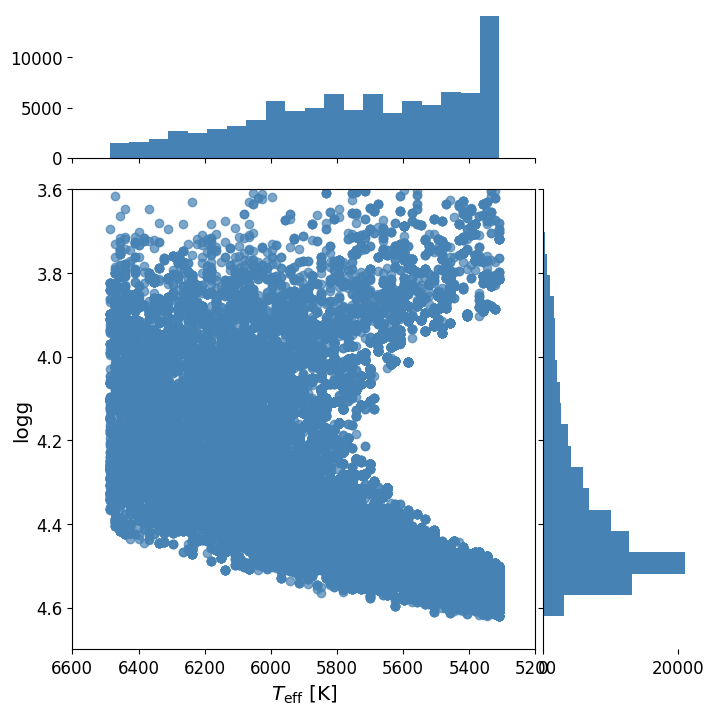

In [489]:
from matplotlib.gridspec import GridSpec

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1:4, 0:3])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.03, pos.width, pos.height])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

ax_scatter.scatter(tri_matched_to_b23_k2['Teff'], tri_matched_to_b23_k2['logg'], alpha=0.7, c='steelblue')

# histograms
ax_histx.hist(tri_matched_to_b23_k2['Teff'], bins=20, color="steelblue")
ax_histy.hist(tri_matched_to_b23_k2['logg'], bins=20, orientation='horizontal', color="steelblue")
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K]")
ax_scatter.set_ylabel('logg')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
ax_scatter.set_xlim([6600, 5200])
ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label=r'Cannon model reduced $\chi^2$ fit')
plt.tight_layout()
plt.savefig(path+'plots/k2/kiel_tri_b23_match_sampled.png')
plt.show()

In [492]:
k2_stars_bootstrapped

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error,parallax,zmax,age,Teff,logg
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.009947,0.014552,0.023659,0.011433,0.764247,2.157181,0.819130,6.80,5749.25,4.18
1,epic201384232,5617.490904,104.439531,-112.920238,4.504207,0.031620,-0.054677,-0.067026,0.133046,-0.128326,...,0.009171,0.016791,0.017660,0.011535,1.071830,3.167135,0.314432,6.02,5716.22,4.51
2,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,0.010187,0.013297,0.015633,0.012143,2.168792,1.451126,0.867528,5.62,6361.46,4.13
3,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,0.011357,0.016955,0.016465,0.012123,1.045084,2.252150,0.570358,4.44,6354.85,4.24
4,epic201445732,5855.091952,142.109696,-165.527870,4.370385,0.057779,-0.071913,-0.008679,0.145500,-0.135597,...,0.012602,0.017214,0.015770,0.014879,1.030092,3.200969,0.688785,6.02,5956.26,4.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.012035,0.020601,0.019146,0.014207,0.576840,2.195042,0.283743,6.67,5987.09,4.21
338,epic211914998,5506.434626,100.491856,-107.050256,4.516862,0.029614,-0.053160,-0.003695,0.138075,-0.129787,...,0.006844,0.016967,0.017220,0.011867,1.617407,2.143024,0.383956,3.65,5480.58,4.51
339,epic211929937,5120.873317,85.776292,-93.976022,4.541658,0.036672,-0.059382,0.092489,0.139585,-0.138446,...,0.013214,0.024675,0.024626,0.017039,4.315491,1.997430,0.395186,8.12,5302.20,4.43
340,epic211962097,6212.505919,166.837618,-154.772263,3.931147,0.049014,-0.062616,-0.164533,0.138264,-0.129350,...,0.008343,0.015626,0.016552,0.012772,6.055880,0.719913,0.957029,3.39,6158.86,3.89


<Figure size 800x800 with 0 Axes>

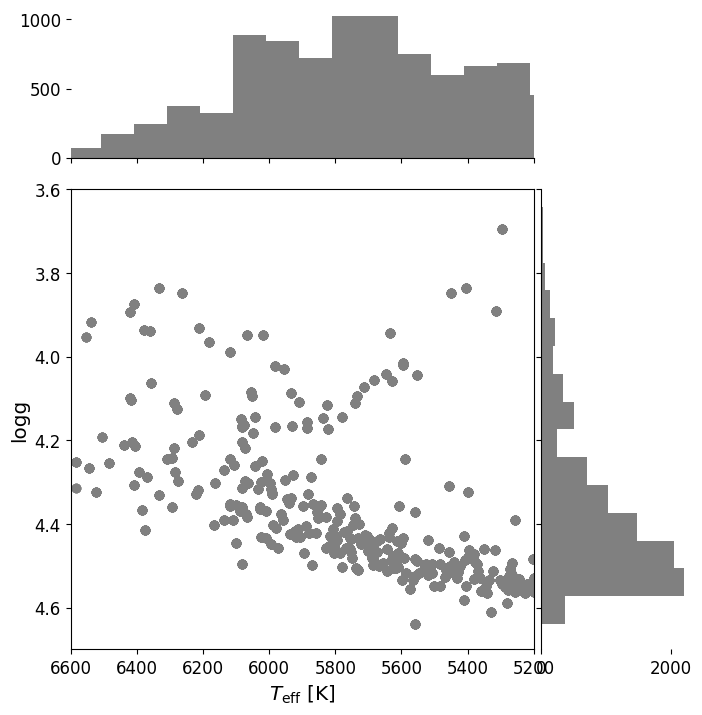

In [491]:
from matplotlib.gridspec import GridSpec

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1:4, 0:3])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.03, pos.width, pos.height])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

ax_scatter.scatter(k2_stars_bootstrapped['iso_teff'], k2_stars_bootstrapped['iso_logg'], alpha=0.7, c='gray')

# histograms
ax_histx.hist(k2_stars_bootstrapped['iso_teff'], bins=20, color="gray")
ax_histy.hist(k2_stars_bootstrapped['iso_logg'], bins=20, orientation='horizontal', color="gray")
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K]")
ax_scatter.set_ylabel('logg')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
ax_scatter.set_xlim([6600, 5200])
ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label=r'Cannon model reduced $\chi^2$ fit')
plt.tight_layout()
plt.savefig(path+'plots/k2/kiel_b23_bootstrapped.png')
plt.show()

median Teff:  6011.737374832779
median age:  3.926044708445311


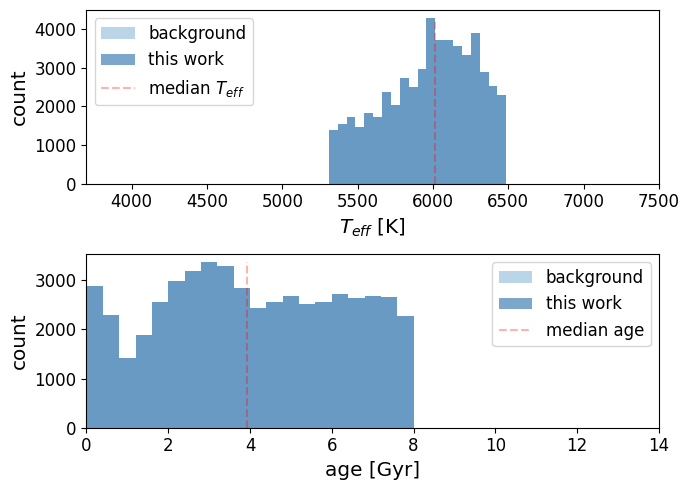

In [493]:
def plot_properties(df, label):

	if label=='TRI':
		df_sub = df.loc[(df['Teff'] >= 5300) & (df['Teff'] <= 6500)] # what we actually use
		df_sub = df_sub.loc[(df_sub['age'] >= 0) & (df_sub['age'] <= 8)]
		teffs = df['Teff']
		ages = df['age']
		teffs_sub = df_sub['Teff']
		ages_sub = df_sub['age']
	elif label=='B23':
		df_sub = df.loc[(df['iso_teff'] >= 5300) & (df['iso_teff'] <= 6500)] # what we actually use
		df_sub = df_sub.loc[(df_sub['iso_age'] >= 0) & (df_sub['iso_age'] <= 8)]
		teffs = df['iso_teff']
		ages = df['iso_age']
		teffs_sub = df_sub['iso_teff']
		ages_sub = df_sub['iso_age']

	### VISUALIZE TRILEGAL SAMPLE PROPERTIES, FOR PAPER FIGURE
	#teff_hist, teff_bin_edges = np.histogram(teffs, bins=50)
	#print("Teff peak: ", teff_bin_edges[np.argmax(teff_hist)])
	#age_hist, age_bin_edges = np.histogram(ages, bins=50)
	#print("age peak: ", age_bin_edges[np.argmax(age_hist)])

	#fig, axes = plt.subplots(figsize=(7,5))
	fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 5))

	### TEFF
	#ax1 = plt.subplot2grid((2,1), (0,0))
	ax1.hist(teffs, bins=20, alpha=0.3, label='background') # background
	bins, edges, patches = ax1.hist(teffs_sub, bins=20, alpha=0.7, color='steelblue', label='this work') # what we actually use
	ax1.set_ylabel("count")
	ax1.set_xlabel(r"$T_{eff}$ [K]")
	# plot vertical red line through median Teff

	ax1.plot([np.median(teffs_sub), np.median(teffs_sub)], 
			[0,np.max(bins)], color='r', alpha=0.3, linestyle='--', label=r'median $T_{eff}$')
	ax1.set_xlim([3700, 7500])
	ax1.legend()

	### AGE
	#ax2 = plt.subplot2grid((2,1), (1,0))
	ax2.hist(ages, bins=20, alpha=0.3, label='background') # background
	bins, edges, patches = ax2.hist(ages_sub, bins=20, alpha=0.7, color='steelblue', label='this work') # what we actually use
	# plot vertical red line through median age 
	ax2.plot([np.median(ages_sub), np.median(ages_sub)], 
			[0,np.max(bins)], color='r', alpha=0.3, linestyle='--', label='median age')
	ax2.set_ylabel("count")
	ax2.set_xlabel("age [Gyr]")
	ax2.set_xlim([0, 14])
	ax2.legend()
	fig.tight_layout()
	plt.savefig(path+'plots/k2/sample_properties_tri_match_sampled.png')

	print("median Teff: ", np.median(teffs_sub))
	print("median age: ", np.median(ages_sub))


plot_properties(tri_k2, label='TRI')

#### Campaign 4: https://stev.oapd.inaf.it/tmp/output677834275019.dat

In [238]:
test4 = pd.read_csv(path+'data/k2/trilegal/test_campaign4.txt', sep='\s+')
# remove binaries
test4 = test4[test4['m2/m1']==0]
print(len(test4))

# add height column, introducing a spread of 0.05 dex based on TRILEGAL distance modulus bin size
test4['distance'] = simulate_helpers.distance_modulus_to_distance(test4['m-M0'], perturb=True)
test4['height'] = dist_k2_to_height(test4['distance'], b4)

# unlog Teff. keep FGK dwarfs only
test4['Teff'] = 10**test4['logTe'].astype(float)
test4 = test4.loc[(test4['Teff'] <= 7500) & (test4['Teff'] >= 3700)] 
print(len(test4))

# TRILEGAL logAge bin size is 0.02, so let's introduce a spread of that size; note from Luke Bouma (https://github.com/lgbouma/gyrojo/blob/main/gyrojo/trilegal.py#L92-L108)
eps = np.random.normal(loc=0, scale=0.02, size=len(test4))
test4['logAge'] = test4['logAge'].astype(float)
test4['logAge'] += eps
test4['age'] = 10**test4['logAge'].astype(float) / 1e9

# age cut for uniformity
test4 = test4.loc[test4['age'] <= 8.]
print(len(test4))

# calculate stellar radius
test4['stellar_radius'] = simulate_helpers.stellar_radius_stefan_boltzmann(10**test4['logTe'], 10**test4['logL'])

# extrapolate CDPP based on Zink+20
#my_k2 = simulate_helpers.kepmag_to_cdpp_vectorized(k2_stars, my_k2) # cdpp distribution is similar to B20 sample

test4 = test4.reset_index()
test4

1519
1480
1193


,index,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,...,DDO51_finf,J,H,Ks,Mact,distance,height,Teff,age,stellar_radius
0,3,1,7.724757,0.27,0.54993,-1.283,3.600,4.809,7.199157,0.034,...,16.983,13.492,12.819,12.690,0.550,275.315947,120.461522,3981.071706,0.053059,0.481046
1,5,1,7.837758,0.15,0.64647,-1.040,3.628,4.746,6.336151,0.030,...,15.262,12.188,11.514,11.403,0.646,185.024921,80.955658,4246.195639,0.068827,0.559353
2,6,1,7.891715,0.27,1.53807,0.711,3.846,4.245,6.444411,0.031,...,9.478,8.782,8.654,8.629,1.538,194.483245,85.094046,7014.552984,0.077932,1.538814
3,8,1,7.983863,0.23,1.23361,0.266,3.789,4.366,11.274259,0.038,...,15.422,14.307,14.062,14.027,1.234,1798.256883,786.807899,6151.768727,0.096352,1.198633
4,9,1,8.005505,-0.05,0.62375,-1.063,3.630,4.761,6.535707,0.031,...,15.363,12.362,11.693,11.583,0.624,202.834265,88.747944,4265.795188,0.101276,0.539742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,2017,1,9.900688,-0.23,0.99050,0.201,3.778,4.288,10.172920,0.038,...,14.726,13.539,13.252,13.215,0.991,1082.889315,473.806537,5997.910763,7.955867,1.170001
1189,2021,1,9.886880,-0.19,1.03245,0.352,3.779,4.160,11.993273,0.038,...,16.041,14.865,14.582,14.545,1.032,2504.116371,1095.649103,6011.737375,7.706904,1.385754
1190,2023,1,9.886827,-0.17,0.99584,0.210,3.775,4.274,8.805092,0.038,...,13.206,12.004,11.714,11.676,0.996,576.790935,252.368651,5956.621435,7.705965,1.198633
1191,2027,1,9.886426,-0.15,1.09757,0.552,3.699,3.669,11.397102,0.038,...,15.279,13.432,12.951,12.881,1.098,1902.919753,832.602009,5000.345350,7.698858,2.521658


<Figure size 800x800 with 0 Axes>

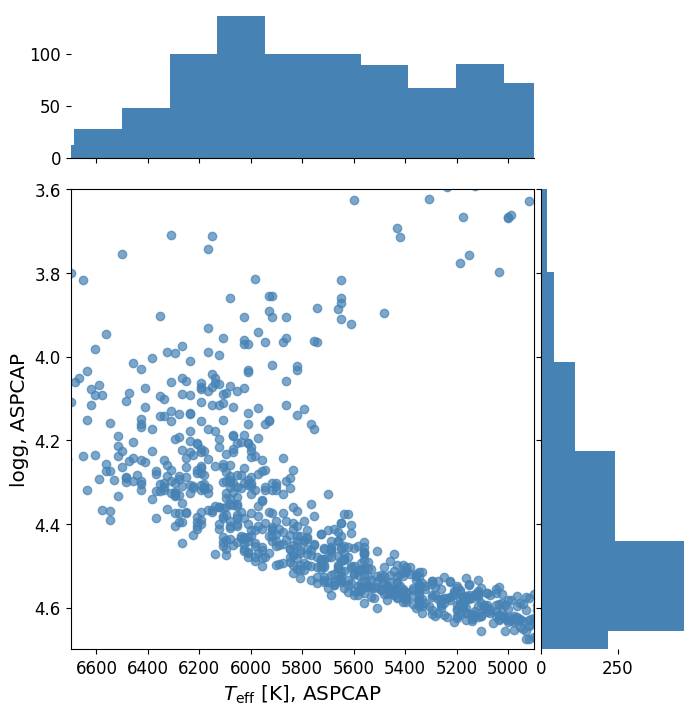

In [239]:
# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.05, hspace=0.05)

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1:4, 0:3])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.03, pos.width, pos.height])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

ax_scatter.scatter(test4['Teff'], test4['logg'], alpha=0.7, c='steelblue')

# histograms
ax_histx.hist(test4['Teff'], bins=20, color="steelblue")
ax_histy.hist(test4['logg'], bins=20, orientation='horizontal', color="steelblue")
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K], ASPCAP")
ax_scatter.set_ylabel('logg, ASPCAP')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
ax_scatter.set_xlim([6700, 4900])
ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label=r'Cannon model reduced $\chi^2$ fit')
plt.tight_layout()
#plt.savefig(path+'plots/k2/kiel_tri_b23.png')
plt.show()

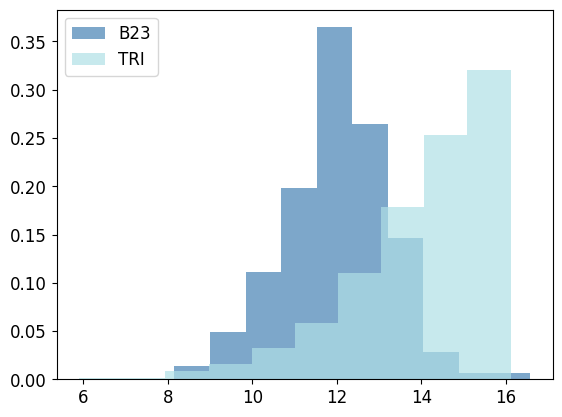

In [240]:
plt.hist(k2_stars['rpmag'], label='B23', alpha=0.7, color='steelblue', density=True)
plt.hist(test4['r'], label='TRI', alpha=0.7, color='powderblue', density=True)
plt.legend()
plt.show()

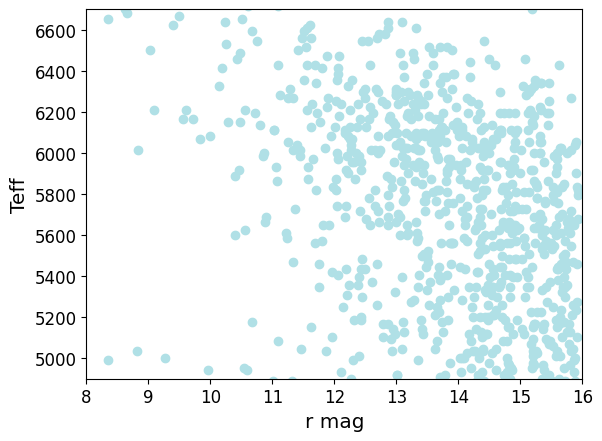

In [241]:
plt.scatter(test4['r'], test4['Teff'], label='TRI', color='powderblue')
plt.xlabel('r mag')
plt.ylabel('Teff')
plt.xlim([8, 16])
plt.ylim([4900, 6700])
plt.show()

0       0.053059
1       0.068827
2       0.077932
3       0.096352
4       0.101276
          ...   
1188    7.955867
1189    7.706904
1190    7.705965
1191    7.698858
1192    7.677510
Name: age, Length: 1193, dtype: float64
0        120.461522
1         80.955658
2         85.094046
3        786.807899
4         88.747944
           ...     
1188     473.806537
1189    1095.649103
1190     252.368651
1191     832.602009
1192     830.751698
Name: height, Length: 1193, dtype: float64


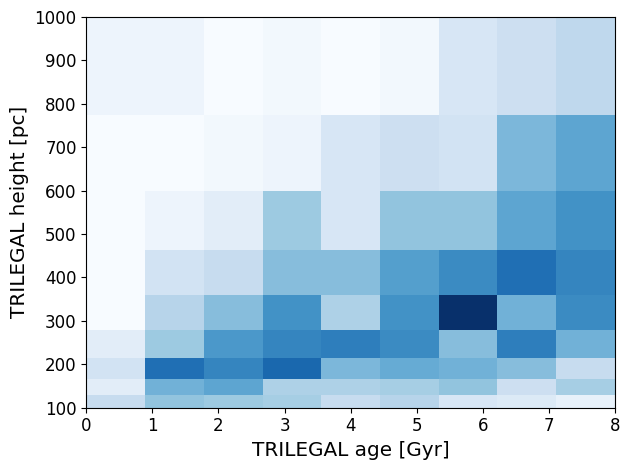

In [242]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='TRI'
ages = test4['age']
heights = test4['height']
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
	plt.tight_layout()
	#plt.savefig(path+'plots/k2/age_vs_height_TRI.png')
	plt.show()

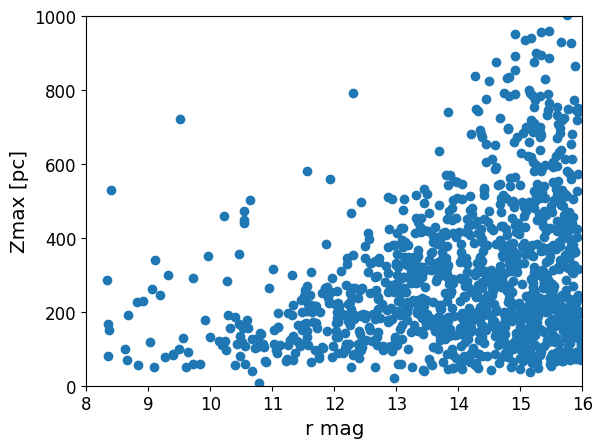

In [243]:
plt.scatter(test4['r'], test4['height'])
plt.xlabel('r mag')
plt.ylabel('Zmax [pc]')
plt.ylim([0, 1000])
plt.xlim([8, 16])
plt.show()

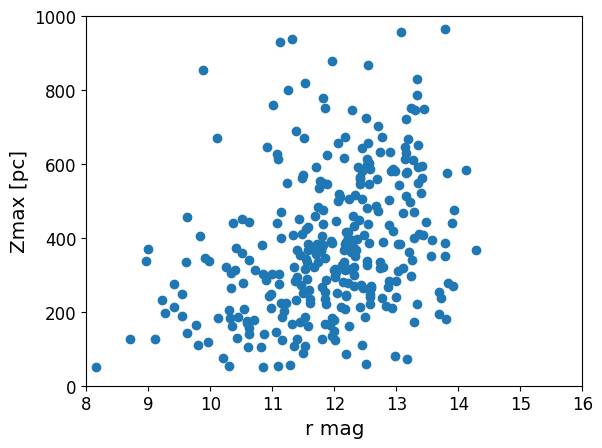

In [212]:
plt.scatter(k2_stars['rpmag'], k2_stars['zmax']*1000)
plt.xlabel('r mag')
plt.ylabel('Zmax [pc]')
plt.ylim([0, 1000])
plt.xlim([8, 16])
plt.show()

Paint planets upon the sample

In [ ]:
# planet formation history model parameters
threshold = 12 # cosmic age in Gyr; 13.7 minus stellar age, then round
frac1 = 0.20 # frac1 must be < frac2 if comparing cosmic ages
frac2 = 0.95

name_thresh = 12
name_f1 = 20
name_f2 = 95
name = 'step_'+str(name_thresh)+'_'+str(name_f1)+'_'+str(name_f2)

pop = Population(tri_k2['age'], threshold, frac1, frac2)
frac_hosts = pop.galactic_occurrence_step(threshold, frac1, frac2)
#frac_hosts = pop.galactic_occurrence_monotonic(frac1, frac2)
#frac_hosts = pop.galactic_occurrence_piecewise(frac1, frac2, threshold)
intact_fracs = scipy.stats.truncnorm.rvs(0, 1, loc=0.18, scale=0.1, size=len(my_k2))  

alpha_se = np.random.normal(-1., 0.2)
alpha_sn = np.random.normal(-1.5, 0.1)

# create Star objects, with their planetary systems
star_data = []
for i in tqdm(range(len(my_k2))): 
    star = Star(my_k2['age'][i], my_k2['stellar_radius'][i], my_k2['Mact'][i], my_k2['Teff'], my_k2['cdpp'][i], my_k2['height'][i], alpha_se, alpha_sn, frac_hosts[i], intact_fracs[i])
    star_update = {
        'kepid': star.kepid,
        'age': star.age,
        'stellar_radius': star.stellar_radius,
        'stellar_mass': star.stellar_mass,
        'Teff': star.Teff,
        'rrmscdpp06p0': star.rrmscdpp06p0,
        'frac_host': star.frac_host,
        'height': star.height,
        'midplane': star.midplane,
        'prob_intact': star.prob_intact,
        'status': star.status,
        'sigma_incl': star.sigma_incl,
        'num_planets': star.num_planets,
        'periods': star.periods,
        'incls': star.incls,
        'mutual_incls': star.mutual_incls,
        'eccs': star.eccs,
        'omegas': star.omegas,
        'planet_radii': star.planet_radii
    }
    star_data.append(star_update)
    pop.add_child(star)

# convert back to DataFrame
#j = 0
trilegal_k2 = pd.DataFrame.from_records(star_data)

"""
# why are physical occurrences rising at greater heights all of a sudden??
trilegal_kepler_all['height_bins'] = pd.cut(trilegal_kepler_all['height'], bins = np.logspace(2,3,6), include_lowest=True)
trilegal_physical_counts = trilegal_kepler_all.groupby(['height_bins'])['kepid'].count()
print(trilegal_physical_counts)
print(trilegal_physical_counts['kepid'])
quit()
trilegal_physical_counts = trilegal_physical_counts[['height_bins',0]]
trilegal_physical_counts.columns = ['height_bins', 'height_bin_counts']
print(np.array(trilegal_physical_counts['height_bin_counts']))
quit()
"""

trilegal_k2.to_csv(path+'data/trilegal_k2/'+name+'/'+name+'_'+str(j)+'.csv')

  0%|          | 0/12678 [00:00<?, ?it/s]


KeyError: 'cdpp'